In [1]:
# pip install -r requirements.txt

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os

import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [4]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [5]:
# Since we are using google drive for the data, Loading the Drive helper and mounting the same
#from google.colab import drive
#drive.mount('/content/drive')
# Defining data directory
# dataset_dir = "/content/drive/My Drive/PES-Project/home-credit-default-risk"
# If you are using local files, set the dataset directory accordingly
# Since google colab was crashing, we are using local files

dataset_dir = "/Users/shrikantyalakki/Documents/PES/Sem-IV/Projects/Credit-Risk-Analysis/Data"

In [6]:
# a) bureau.csv
bureau = pd.read_csv(f"{dataset_dir}/bureau.csv")
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [7]:
# Check basic info and null values
bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


In [8]:
# Columns with null values
null_summary = bureau.isnull().sum()/len(bureau) * 100  # % of null per column
null_summary[null_summary>0].sort_values(ascending=False)

AMT_ANNUITY               71.473490
AMT_CREDIT_MAX_OVERDUE    65.513264
DAYS_ENDDATE_FACT         36.916958
AMT_CREDIT_SUM_LIMIT      34.477415
AMT_CREDIT_SUM_DEBT       15.011932
DAYS_CREDIT_ENDDATE        6.149573
AMT_CREDIT_SUM             0.000757
dtype: float64

In [9]:
bureau.describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,1716428.0,2.782149e+05,1.029386e+05,100001.000,188866.75,278055.0,367426.00,4.562550e+05
SK_ID_BUREAU,1716428.0,5.924434e+06,5.322657e+05,5000000.000,5463953.75,5926303.5,6385681.25,6.843457e+06
DAYS_CREDIT,1716428.0,-1.142108e+03,7.951649e+02,-2922.000,-1666.00,-987.0,-474.00,0.000000e+00
CREDIT_DAY_OVERDUE,1716428.0,8.181666e-01,3.654443e+01,0.000,0.00,0.0,0.00,2.792000e+03
DAYS_CREDIT_ENDDATE,1610875.0,5.105174e+02,4.994220e+03,-42060.000,-1138.00,-330.0,474.00,3.119900e+04
DAYS_ENDDATE_FACT,1082775.0,-1.017437e+03,7.140106e+02,-42023.000,-1489.00,-897.0,-425.00,0.000000e+00
AMT_CREDIT_MAX_OVERDUE,591940.0,3.825418e+03,2.060316e+05,0.000,0.00,0.0,0.00,1.159872e+08
CNT_CREDIT_PROLONG,1716428.0,6.410406e-03,9.622391e-02,0.000,0.00,0.0,0.00,9.000000e+00
AMT_CREDIT_SUM,1716415.0,3.549946e+05,1.149811e+06,0.000,51300.00,125518.5,315000.00,5.850000e+08
AMT_CREDIT_SUM_DEBT,1458759.0,1.370851e+05,6.774011e+05,-4705600.320,0.00,0.0,40153.50,1.701000e+08


In [10]:
# Assuming the null values in numeric columns means there is no outstanding.
# Replacing null values with 0
numeric_cols = bureau.select_dtypes(include='number').columns.tolist()
bureau[numeric_cols] = bureau[numeric_cols].fillna(0)

In [11]:
# After imputing checking Columns with null values
null_summary = bureau.isnull().sum()/len(bureau) * 100  # % of null per column
null_summary[null_summary>0].sort_values(ascending=False)

Series([], dtype: float64)

In [12]:
agg_bureau = bureau.groupby('SK_ID_CURR').agg({
    'SK_ID_BUREAU': 'count',
    'AMT_CREDIT_SUM': 'sum',
    'AMT_CREDIT_SUM_DEBT': 'sum',
    'AMT_CREDIT_SUM_OVERDUE': 'max',
    'CREDIT_ACTIVE': lambda x: (x == 'Active').sum(),
    'CREDIT_TYPE': pd.Series.nunique
}).rename(columns={
    'SK_ID_BUREAU':'BURO_RECORDS_CNT',
    'AMT_CREDIT_SUM':'BURO_TOTAL_CREDIT',
    'AMT_CREDIT_SUM_DEBT':'BURO_TOTAL_DEBT',
    'AMT_CREDIT_SUM_OVERDUE':'BURO_MAX_OVERDUE',
    'CREDIT_ACTIVE':'BURO_ACTIVE_CREDITS',
    'CREDIT_TYPE':'BURO_NUM_CREDIT_TYPES'
})

In [13]:
# b) bureau_balance.csv
bureau_bal = pd.read_csv(f"{dataset_dir}/bureau_balance.csv")
bureau_bal.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [14]:
# Columns with null values
null_summary = bureau_bal.isnull().sum()/len(bureau_bal) * 100  # % of null per column
null_summary[null_summary>0].sort_values(ascending=False)

Series([], dtype: float64)

<b><i>Label Encoding STATUS</i></b>

<b>STATUS codes: </b>

Numeric code ('0'-'5'): how many months past due.
'C': closed.
'X': no loan for that month.
Mapping to numeric in order of risk:

In [15]:
# Risk-ordered mapping for STATUS
status_map = {'C': 0, '0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6, 'X': 1}
bureau_bal['STATUS_NUM'] = bureau_bal['STATUS'].map(status_map)

In [16]:
bureau_bal_agg = bureau_bal.groupby('SK_ID_BUREAU').agg(
    BB_MONTHS_MIN=('MONTHS_BALANCE', 'min'),   # How far back does this record go
    BB_MONTHS_MAX=('MONTHS_BALANCE', 'max'),
    BB_MONTHS_COUNT=('MONTHS_BALANCE', 'count'),
    BB_STATUS_CLOSED=('STATUS', lambda x: (x == 'C').sum()),  # Count closed months
    BB_STATUS_X=('STATUS', lambda x: (x == 'X').sum()),     # Count no-loan months
    BB_STATUS_0=('STATUS', lambda x: (x == '0').sum()),     # On-time months
    BB_STATUS_past_due=('STATUS', lambda x: sum(x.isin(['1', '2', '3', '4', '5']))),  # Past-due months
    BB_STATUS_MAX=('STATUS_NUM', 'max'),
    BB_STATUS_MEAN=('STATUS_NUM', 'mean')
).reset_index()

In [17]:
bureau_bal_agg.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in bureau_bal_agg.columns.values]

# Rename the index column generated by reset_index()
bureau_bal_agg.rename(columns={'index': 'SK_ID_BUREAU'}, inplace=True)

In [18]:
bureau = bureau.merge(bureau_bal_agg, how='left', on='SK_ID_BUREAU')

In [19]:
bureau_agg = bureau.groupby('SK_ID_CURR').agg(
    # Overall stats
    BURO_LOAN_COUNT=('SK_ID_BUREAU', 'count'),
    BURO_ACTIVE=('CREDIT_ACTIVE', lambda x: (x == 'Active').sum()),
    BURO_CLOSED=('CREDIT_ACTIVE', lambda x: (x == 'Closed').sum()),
    OVERDUE_DAYS_MAX=('DAYS_CREDIT_ENDDATE', lambda x: (x < 0).sum()),
    CREDIT_SUM_OVERALL=('AMT_CREDIT_SUM', 'sum'),
    OVERDUE_OVERALL=('AMT_CREDIT_SUM_OVERDUE', 'sum'),
    ANNUITY_OVERALL=('AMT_ANNUITY', 'sum'),
    CREDIT_TYPE_NUNIQUE=('CREDIT_TYPE', 'nunique'),
    # Aggregated bureau_balance sub-features
    BB_STATUS_MEAN=('BB_STATUS_MEAN', 'mean'),
    BB_STATUS_MAX=('BB_STATUS_MAX', 'max'),
    BB_NMONTHS=('BB_MONTHS_COUNT', 'sum')
).reset_index()

In [20]:
pos = pd.read_csv(f"{dataset_dir}/POS_CASH_balance.csv")
pos.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [21]:
pos.isnull().sum()/len(pos) * 100

SK_ID_PREV               0.000000
SK_ID_CURR               0.000000
MONTHS_BALANCE           0.000000
CNT_INSTALMENT           0.260675
CNT_INSTALMENT_FUTURE    0.260835
NAME_CONTRACT_STATUS     0.000000
SK_DPD                   0.000000
SK_DPD_DEF               0.000000
dtype: float64

In [22]:
# Filling missing value with 0
pos[['CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE']] = pos[['CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE']].fillna(0)

In [23]:
# Since NAME_CONTRACT_STATUS is a categorical column, converting the same into numeric using Label encoder
le = LabelEncoder()
pos['NAME_CONTRACT_STATUS'] = le.fit_transform(pos['NAME_CONTRACT_STATUS'])

In [24]:
# Now aggregating the data based on SK_ID_CURR

pos_agg = pos.groupby('SK_ID_CURR').agg(
    POS_COUNT=('SK_ID_PREV', 'nunique'),
    POS_STATUS_MEAN=('NAME_CONTRACT_STATUS', 'mean'),
    POS_STATUS_MAX=('NAME_CONTRACT_STATUS', 'max'),
    POS_OVERDUE=('SK_DPD', lambda x: (x > 0).sum()),
    POS_OVERDUE_MEAN=('SK_DPD', 'mean'),
    POS_DPD_MAX=('SK_DPD', 'max')
).reset_index()


In [25]:
credit_card_balance = pd.read_csv(f"{dataset_dir}/credit_card_balance.csv")
credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [26]:
credit_card_balance.select_dtypes(include=['object']).columns.tolist()

['NAME_CONTRACT_STATUS']

In [27]:
credit_card_balance.NAME_CONTRACT_STATUS.value_counts()

NAME_CONTRACT_STATUS
Active           3698436
Completed         128918
Signed             11058
Demand              1365
Sent proposal        513
Refused               17
Approved               5
Name: count, dtype: int64

In [28]:
# Encode NAME_CONTRACT_STATUS for aggregation
le = LabelEncoder()
credit_card_balance['NAME_CONTRACT_STATUS_ENC'] = le.fit_transform(credit_card_balance['NAME_CONTRACT_STATUS'])

In [29]:
# Aggregate categorical status data per customer
cat_status_agg = credit_card_balance.pivot_table(
    index='SK_ID_CURR',
    columns='NAME_CONTRACT_STATUS',
    values='SK_ID_PREV',
    aggfunc='count',
    fill_value=0
)
cat_status_agg.columns = [f"CC_STATUS_COUNT_{str(col)}" for col in cat_status_agg.columns]
cat_status_agg = cat_status_agg.reset_index()
cat_status_agg.head()

,SK_ID_CURR,CC_STATUS_COUNT_Active,CC_STATUS_COUNT_Approved,CC_STATUS_COUNT_Completed,CC_STATUS_COUNT_Demand,CC_STATUS_COUNT_Refused,CC_STATUS_COUNT_Sent proposal,CC_STATUS_COUNT_Signed
0,100006,6,0,0,0,0,0,0
1,100011,74,0,0,0,0,0,0
2,100013,96,0,0,0,0,0,0
3,100021,7,0,10,0,0,0,0
4,100023,8,0,0,0,0,0,0


In [30]:
(credit_card_balance.isnull().sum()/len(credit_card_balance) * 100).sort_values(ascending=False)

AMT_PAYMENT_CURRENT           19.998063
CNT_DRAWINGS_ATM_CURRENT      19.524872
AMT_DRAWINGS_ATM_CURRENT      19.524872
AMT_DRAWINGS_OTHER_CURRENT    19.524872
AMT_DRAWINGS_POS_CURRENT      19.524872
CNT_DRAWINGS_POS_CURRENT      19.524872
CNT_DRAWINGS_OTHER_CURRENT    19.524872
CNT_INSTALMENT_MATURE_CUM      7.948208
AMT_INST_MIN_REGULARITY        7.948208
SK_ID_PREV                     0.000000
SK_DPD_DEF                     0.000000
SK_DPD                         0.000000
NAME_CONTRACT_STATUS           0.000000
CNT_DRAWINGS_CURRENT           0.000000
AMT_RECEIVABLE_PRINCIPAL       0.000000
AMT_TOTAL_RECEIVABLE           0.000000
AMT_RECIVABLE                  0.000000
SK_ID_CURR                     0.000000
AMT_PAYMENT_TOTAL_CURRENT      0.000000
AMT_DRAWINGS_CURRENT           0.000000
AMT_CREDIT_LIMIT_ACTUAL        0.000000
AMT_BALANCE                    0.000000
MONTHS_BALANCE                 0.000000
NAME_CONTRACT_STATUS_ENC       0.000000
dtype: float64

In [31]:
agg_funcs = {
    'AMT_BALANCE': ['mean', 'max', 'min', 'sum'],
    'AMT_CREDIT_LIMIT_ACTUAL': ['mean', 'max', 'min', 'sum'],
    'AMT_DRAWINGS_ATM_CURRENT': ['mean', 'max', 'sum'],
    'AMT_DRAWINGS_OTHER_CURRENT': ['mean', 'max', 'sum'],
    'AMT_DRAWINGS_POS_CURRENT': ['mean', 'max', 'sum'],
    'AMT_DRAWINGS_CURRENT': ['mean', 'max', 'sum'],
    'AMT_PAYMENT_CURRENT': ['mean', 'max', 'sum'],
    'AMT_RECEIVABLE_PRINCIPAL': ['mean', 'max', 'sum'],
    'AMT_RECIVABLE': ['mean', 'max', 'sum'],
    'AMT_TOTAL_RECEIVABLE': ['mean', 'max', 'sum'],
    'CNT_DRAWINGS_ATM_CURRENT': ['mean', 'max', 'sum'],
    'CNT_DRAWINGS_OTHER_CURRENT': ['mean', 'max', 'sum'],
    'CNT_DRAWINGS_POS_CURRENT': ['mean', 'max', 'sum'],
    'CNT_DRAWINGS_CURRENT': ['mean', 'max', 'sum'],
    'CNT_INSTALMENT_MATURE_CUM': ['mean', 'max', 'sum'],
    'MONTHS_BALANCE': ['min', 'max', 'count'],
    'SK_DPD': ['mean', 'max', 'sum'],
    'SK_DPD_DEF': ['mean', 'max', 'sum'],
    'AMT_INST_MIN_REGULARITY': ['mean', 'max', 'sum'],
    'AMT_INST_MIN_REGULARITY_NULL': ['max', 'sum'],
    'NAME_CONTRACT_STATUS_ENC': ['mean', 'max', 'min']  # Encoded status trend
}

In [32]:
# Before aggregation, check if all aggregation keys exist in dataset to avoid errors
existing_cols = [col for col in agg_funcs.keys() if col in credit_card_balance.columns]

In [33]:
credit_card_agg = credit_card_balance.groupby('SK_ID_CURR').agg({col: agg_funcs[col] for col in existing_cols})
credit_card_agg.head()

AMT_BALANCE                              AMT_CREDIT_LIMIT_ACTUAL  \
                    mean        max  min          sum                    mean   
SK_ID_CURR                                                                      
100006          0.000000       0.00  0.0        0.000           270000.000000   
100011      54482.111149  189000.00  0.0  4031676.225           164189.189189   
100013      18159.919219  161420.22  0.0  1743352.245           131718.750000   
100021          0.000000       0.00  0.0        0.000           675000.000000   
100023          0.000000       0.00  0.0        0.000           135000.000000   

                                     AMT_DRAWINGS_ATM_CURRENT            ...  \
               max     min       sum                     mean       max  ...   
SK_ID_CURR                                                               ...   
100006      270000  270000   1620000                      NaN       NaN  ...   
100011      180000   90000  12150000              2432.432432  180000.0  ...   
100013      157500   45000  12645000              6350.000000  157500.0  ...   
100021      675000  675000  11475000                      NaN       NaN  ...   
100023      225000   45000   1080000                      NaN       NaN  ...   

           SK_DPD SK_DPD_DEF         AMT_INST_MIN_REGULARITY          \
              sum       mean max sum                    mean     max   
SK_ID_CURR                                                             
100006          0   0.000000   0   0                0.000000     0.0   
100011          0   0.000000   0   0             3956.221849  9000.0   
100013          1   0.010417   1   1             1454.539551  7875.0   
100021          0   0.000000   0   0                0.000000     0.0   
100023          0   0.000000   0   0                0.000000     0.0   

                       NAME_CONTRACT_STATUS_ENC          
                   sum                     mean max min  
SK_ID_CURR                                               
100006           0.000                 0.000000   0   0  
100011      288804.195                 0.000000   0   0  
100013      129454.020                 0.000000   0   0  
100021           0.000                 1.176471   2   0  
100023           0.000                 0.000000   0   0  

[5 rows x 62 columns]

In [34]:
# Flatten multi-level columns
credit_card_agg.columns = ['_'.join(col).strip() for col in credit_card_agg.columns.values]
credit_card_agg = credit_card_agg.reset_index()
credit_card_agg.head()

,SK_ID_CURR,AMT_BALANCE_mean,AMT_BALANCE_max,AMT_BALANCE_min,AMT_BALANCE_sum,AMT_CREDIT_LIMIT_ACTUAL_mean,AMT_CREDIT_LIMIT_ACTUAL_max,AMT_CREDIT_LIMIT_ACTUAL_min,AMT_CREDIT_LIMIT_ACTUAL_sum,AMT_DRAWINGS_ATM_CURRENT_mean,...,SK_DPD_sum,SK_DPD_DEF_mean,SK_DPD_DEF_max,SK_DPD_DEF_sum,AMT_INST_MIN_REGULARITY_mean,AMT_INST_MIN_REGULARITY_max,AMT_INST_MIN_REGULARITY_sum,NAME_CONTRACT_STATUS_ENC_mean,NAME_CONTRACT_STATUS_ENC_max,NAME_CONTRACT_STATUS_ENC_min
0,100006,0.000000,0.00,0.0,0.000,270000.000000,270000,270000,1620000,NaN,...,0,0.000000,0,0,0.000000,0.0,0.000,0.000000,0,0
1,100011,54482.111149,189000.00,0.0,4031676.225,164189.189189,180000,90000,12150000,2432.432432,...,0,0.000000,0,0,3956.221849,9000.0,288804.195,0.000000,0,0
2,100013,18159.919219,161420.22,0.0,1743352.245,131718.750000,157500,45000,12645000,6350.000000,...,1,0.010417,1,1,1454.539551,7875.0,129454.020,0.000000,0,0
3,100021,0.000000,0.00,0.0,0.000,675000.000000,675000,675000,11475000,NaN,...,0,0.000000,0,0,0.000000,0.0,0.000,1.176471,2,0
4,100023,0.000000,0.00,0.0,0.000,135000.000000,225000,45000,1080000,NaN,...,0,0.000000,0,0,0.000000,0.0,0.000,0.000000,0,0


Prev

In [35]:
# Load the previous_application dataset
previous_application = pd.read_csv(f"{dataset_dir}/previous_application.csv")
previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
previous_application.shape

(1670214, 37)

In [37]:
print("\nColumn null percentages:")
null_pct = previous_application.isnull().mean() * 100
print(null_pct[null_pct > 0].sort_values(ascending=False))


Column null percentages:
RATE_INTEREST_PRIMARY        99.643698
RATE_INTEREST_PRIVILEGED     99.643698
AMT_DOWN_PAYMENT             53.636480
RATE_DOWN_PAYMENT            53.636480
NAME_TYPE_SUITE              49.119754
DAYS_FIRST_DRAWING           40.298129
DAYS_FIRST_DUE               40.298129
DAYS_LAST_DUE_1ST_VERSION    40.298129
DAYS_LAST_DUE                40.298129
DAYS_TERMINATION             40.298129
NFLAG_INSURED_ON_APPROVAL    40.298129
AMT_GOODS_PRICE              23.081773
AMT_ANNUITY                  22.286665
CNT_PAYMENT                  22.286366
PRODUCT_COMBINATION           0.020716
AMT_CREDIT                    0.000060
dtype: float64


In [38]:
print(previous_application.dtypes)

SK_ID_PREV                       int64
SK_ID_CURR                       int64
NAME_CONTRACT_TYPE              object
AMT_ANNUITY                    float64
AMT_APPLICATION                float64
AMT_CREDIT                     float64
AMT_DOWN_PAYMENT               float64
AMT_GOODS_PRICE                float64
WEEKDAY_APPR_PROCESS_START      object
HOUR_APPR_PROCESS_START          int64
FLAG_LAST_APPL_PER_CONTRACT     object
NFLAG_LAST_APPL_IN_DAY           int64
RATE_DOWN_PAYMENT              float64
RATE_INTEREST_PRIMARY          float64
RATE_INTEREST_PRIVILEGED       float64
NAME_CASH_LOAN_PURPOSE          object
NAME_CONTRACT_STATUS            object
DAYS_DECISION                    int64
NAME_PAYMENT_TYPE               object
CODE_REJECT_REASON              object
NAME_TYPE_SUITE                 object
NAME_CLIENT_TYPE                object
NAME_GOODS_CATEGORY             object
NAME_PORTFOLIO                  object
NAME_PRODUCT_TYPE               object
CHANNEL_TYPE             

In [39]:
# Identify categorical columns for label encoding
categorical_cols = previous_application.select_dtypes(include=['object']).columns.tolist()
print("\nCategorical columns found for encoding:")
for col in categorical_cols:
    print(col)


Categorical columns found for encoding:
NAME_CONTRACT_TYPE
WEEKDAY_APPR_PROCESS_START
FLAG_LAST_APPL_PER_CONTRACT
NAME_CASH_LOAN_PURPOSE
NAME_CONTRACT_STATUS
NAME_PAYMENT_TYPE
CODE_REJECT_REASON
NAME_TYPE_SUITE
NAME_CLIENT_TYPE
NAME_GOODS_CATEGORY
NAME_PORTFOLIO
NAME_PRODUCT_TYPE
CHANNEL_TYPE
NAME_SELLER_INDUSTRY
NAME_YIELD_GROUP
PRODUCT_COMBINATION


In [40]:
# 3. Example label encoding for categorical columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    previous_application[col] = previous_application[col].fillna("MISSING")  # handle missing for encoding
    previous_application[col+'_ENC'] = le.fit_transform(previous_application[col])
    label_encoders[col] = le

### installments_payments.csv

In [41]:
installments_payments = pd.read_csv(f"{dataset_dir}/installments_payments.csv")
installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [42]:
installments_payments.shape

(13605401, 8)

In [43]:
# Null value analysis
null_pct = installments_payments.isnull().sum()/len(installments_payments) * 100
print(null_pct[null_pct > 0].sort_values(ascending=False))

DAYS_ENTRY_PAYMENT    0.021352
AMT_PAYMENT           0.021352
dtype: float64


In [44]:
installments_payments.dtypes

SK_ID_PREV                  int64
SK_ID_CURR                  int64
NUM_INSTALMENT_VERSION    float64
NUM_INSTALMENT_NUMBER       int64
DAYS_INSTALMENT           float64
DAYS_ENTRY_PAYMENT        float64
AMT_INSTALMENT            float64
AMT_PAYMENT               float64
dtype: object

In [45]:
# Create delay-related features
# Days past due: how late was the payment (0 if on time or early)
installments_payments['DAYS_PAST_DUE'] = installments_payments['DAYS_ENTRY_PAYMENT'] - installments_payments['DAYS_INSTALMENT']
installments_payments['DAYS_PAST_DUE'] = installments_payments['DAYS_PAST_DUE'].apply(lambda x: x if x > 0 else 0)

In [46]:
# Days before due: early payment days (0 if late or on time)
installments_payments['DAYS_BEFORE_DUE'] = installments_payments['DAYS_INSTALMENT'] - installments_payments['DAYS_ENTRY_PAYMENT']
installments_payments['DAYS_BEFORE_DUE'] = installments_payments['DAYS_BEFORE_DUE'].apply(lambda x: x if x > 0 else 0)

In [47]:
# Aggregation dictionary: aggregate meaningful features per applicant
agg_dict = {
    'NUM_INSTALMENT_VERSION': ['nunique'],  # number of different versions of installments
    'DAYS_INSTALMENT': ['min', 'max', 'mean'],  # schedule days
    'DAYS_ENTRY_PAYMENT': ['min', 'max', 'mean'],  # actual payment days
    'AMT_INSTALMENT': ['min', 'max', 'mean', 'sum'],  # scheduled payment amounts
    'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],  # actual payment amounts
    'DAYS_PAST_DUE': ['min', 'max', 'mean', 'sum', 'count', lambda x: (x > 0).sum()],  # late payment stats
    'DAYS_BEFORE_DUE': ['min', 'max', 'mean', 'sum', 'count', lambda x: (x > 0).sum()],  # early payment stats
}

In [48]:
# Renaming the lambda aggregation functions for better clarity
agg_rename_funcs = {
    '<lambda_0>': 'NUM_LATE_PAYMENTS',
    '<lambda_1>': 'NUM_EARLY_PAYMENTS'
}

In [49]:
# Perform aggregation
installments_agg = installments_payments.groupby('SK_ID_CURR').agg(agg_dict)
installments_agg.head()

NUM_INSTALMENT_VERSION DAYS_INSTALMENT                       \
                          nunique             min     max         mean   
SK_ID_CURR                                                               
100001                          2         -2916.0 -1619.0 -2187.714286   
100002                          2          -565.0   -25.0  -295.000000   
100003                          2         -2310.0  -536.0 -1378.160000   
100004                          2          -784.0  -724.0  -754.000000   
100005                          2          -706.0  -466.0  -586.000000   

           DAYS_ENTRY_PAYMENT                      AMT_INSTALMENT              \
                          min     max         mean            min         max   
SK_ID_CURR                                                                      
100001                -2916.0 -1628.0 -2195.000000       3951.000   17397.900   
100002                 -587.0   -49.0  -315.421053       9251.775   53093.745   
100003                -2324.0  -544.0 -1385.320000       6662.970  560835.360   
100004                 -795.0  -727.0  -761.666667       5357.250   10573.965   
100005                 -736.0  -470.0  -609.555556       4813.200   17656.245   

                          ... DAYS_PAST_DUE                         \
                    mean  ...          mean   sum count <lambda_0>   
SK_ID_CURR                ...                                        
100001       5885.132143  ...      1.571429  11.0     7          1   
100002      11559.247105  ...      0.000000   0.0    19          0   
100003      64754.586000  ...      0.000000   0.0    25          0   
100004       7096.155000  ...      0.000000   0.0     3          0   
100005       6240.205000  ...      0.111111   1.0     9          1   

           DAYS_BEFORE_DUE                                           
                       min   max       mean    sum count <lambda_0>  
SK_ID_CURR                                                           
100001                 0.0  36.0   8.857143   62.0     7          4  
100002                12.0  31.0  20.421053  388.0    19         19  
100003                 1.0  14.0   7.160000  179.0    25         25  
100004                 3.0  11.0   7.666667   23.0     3          3  
100005                 0.0  37.0  23.666667  213.0     9          8  

[5 rows x 27 columns]

In [50]:
# Rename the lambda columns properly
installments_agg.rename(columns={
    col: ('NUM_LATE_PAYMENTS' if 'lambda_0' in col else
          'NUM_EARLY_PAYMENTS' if 'lambda_1' in col else col)
    for col in installments_agg.columns
}, inplace=True)
installments_agg.head()

NUM_INSTALMENT_VERSION DAYS_INSTALMENT                       \
                          nunique             min     max         mean   
SK_ID_CURR                                                               
100001                          2         -2916.0 -1619.0 -2187.714286   
100002                          2          -565.0   -25.0  -295.000000   
100003                          2         -2310.0  -536.0 -1378.160000   
100004                          2          -784.0  -724.0  -754.000000   
100005                          2          -706.0  -466.0  -586.000000   

           DAYS_ENTRY_PAYMENT                      AMT_INSTALMENT              \
                          min     max         mean            min         max   
SK_ID_CURR                                                                      
100001                -2916.0 -1628.0 -2195.000000       3951.000   17397.900   
100002                 -587.0   -49.0  -315.421053       9251.775   53093.745   
100003                -2324.0  -544.0 -1385.320000       6662.970  560835.360   
100004                 -795.0  -727.0  -761.666667       5357.250   10573.965   
100005                 -736.0  -470.0  -609.555556       4813.200   17656.245   

                          ... DAYS_PAST_DUE                         \
                    mean  ...          mean   sum count <lambda_0>   
SK_ID_CURR                ...                                        
100001       5885.132143  ...      1.571429  11.0     7          1   
100002      11559.247105  ...      0.000000   0.0    19          0   
100003      64754.586000  ...      0.000000   0.0    25          0   
100004       7096.155000  ...      0.000000   0.0     3          0   
100005       6240.205000  ...      0.111111   1.0     9          1   

           DAYS_BEFORE_DUE                                           
                       min   max       mean    sum count <lambda_0>  
SK_ID_CURR                                                           
100001                 0.0  36.0   8.857143   62.0     7          4  
100002                12.0  31.0  20.421053  388.0    19         19  
100003                 1.0  14.0   7.160000  179.0    25         25  
100004                 3.0  11.0   7.666667   23.0     3          3  
100005                 0.0  37.0  23.666667  213.0     9          8  

[5 rows x 27 columns]

In [51]:
# Flatten multi-level columns
installments_agg.columns = ['_'.join(col).strip() for col in installments_agg.columns.values]

# Reset index to make SK_ID_CURR a column
installments_agg = installments_agg.reset_index()

# Rename the lambda columns properly after resetting the index
installments_agg.rename(columns={
    col: ('NUM_LATE_PAYMENTS' if 'lambda_0' in col else
          'NUM_EARLY_PAYMENTS' if 'lambda_1' in col else col)
    for col in installments_agg.columns
}, inplace=True)

installments_agg.head()

,SK_ID_CURR,NUM_INSTALMENT_VERSION_nunique,DAYS_INSTALMENT_min,DAYS_INSTALMENT_max,DAYS_INSTALMENT_mean,DAYS_ENTRY_PAYMENT_min,DAYS_ENTRY_PAYMENT_max,DAYS_ENTRY_PAYMENT_mean,AMT_INSTALMENT_min,AMT_INSTALMENT_max,...,DAYS_PAST_DUE_mean,DAYS_PAST_DUE_sum,DAYS_PAST_DUE_count,NUM_LATE_PAYMENTS,DAYS_BEFORE_DUE_min,DAYS_BEFORE_DUE_max,DAYS_BEFORE_DUE_mean,DAYS_BEFORE_DUE_sum,DAYS_BEFORE_DUE_count,NUM_LATE_PAYMENTS
0,100001,2,-2916.0,-1619.0,-2187.714286,-2916.0,-1628.0,-2195.000000,3951.000,17397.900,...,1.571429,11.0,7,1,0.0,36.0,8.857143,62.0,7,4
1,100002,2,-565.0,-25.0,-295.000000,-587.0,-49.0,-315.421053,9251.775,53093.745,...,0.000000,0.0,19,0,12.0,31.0,20.421053,388.0,19,19
2,100003,2,-2310.0,-536.0,-1378.160000,-2324.0,-544.0,-1385.320000,6662.970,560835.360,...,0.000000,0.0,25,0,1.0,14.0,7.160000,179.0,25,25
3,100004,2,-784.0,-724.0,-754.000000,-795.0,-727.0,-761.666667,5357.250,10573.965,...,0.000000,0.0,3,0,3.0,11.0,7.666667,23.0,3,3
4,100005,2,-706.0,-466.0,-586.000000,-736.0,-470.0,-609.555556,4813.200,17656.245,...,0.111111,1.0,9,1,0.0,37.0,23.666667,213.0,9,8


In [52]:
installments_agg.columns.tolist()

['SK_ID_CURR',
 'NUM_INSTALMENT_VERSION_nunique',
 'DAYS_INSTALMENT_min',
 'DAYS_INSTALMENT_max',
 'DAYS_INSTALMENT_mean',
 'DAYS_ENTRY_PAYMENT_min',
 'DAYS_ENTRY_PAYMENT_max',
 'DAYS_ENTRY_PAYMENT_mean',
 'AMT_INSTALMENT_min',
 'AMT_INSTALMENT_max',
 'AMT_INSTALMENT_mean',
 'AMT_INSTALMENT_sum',
 'AMT_PAYMENT_min',
 'AMT_PAYMENT_max',
 'AMT_PAYMENT_mean',
 'AMT_PAYMENT_sum',
 'DAYS_PAST_DUE_min',
 'DAYS_PAST_DUE_max',
 'DAYS_PAST_DUE_mean',
 'DAYS_PAST_DUE_sum',
 'DAYS_PAST_DUE_count',
 'NUM_LATE_PAYMENTS',
 'DAYS_BEFORE_DUE_min',
 'DAYS_BEFORE_DUE_max',
 'DAYS_BEFORE_DUE_mean',
 'DAYS_BEFORE_DUE_sum',
 'DAYS_BEFORE_DUE_count',
 'NUM_LATE_PAYMENTS']

Now scince we have got all the aggregated auxiliary data, lets explore Training dataset

In [53]:
application_train = pd.read_csv(f"{dataset_dir}/application_train.csv")
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
null_percent = round(application_train.isnull().sum()/application_train.shape[0]*100,2).sort_values(ascending=False)
null_percent[null_percent>=35]


COMMONAREA_MEDI                 69.87
COMMONAREA_AVG                  69.87
COMMONAREA_MODE                 69.87
NONLIVINGAPARTMENTS_MODE        69.43
NONLIVINGAPARTMENTS_AVG         69.43
NONLIVINGAPARTMENTS_MEDI        69.43
FONDKAPREMONT_MODE              68.39
LIVINGAPARTMENTS_MODE           68.35
LIVINGAPARTMENTS_AVG            68.35
LIVINGAPARTMENTS_MEDI           68.35
FLOORSMIN_AVG                   67.85
FLOORSMIN_MODE                  67.85
FLOORSMIN_MEDI                  67.85
YEARS_BUILD_MEDI                66.50
YEARS_BUILD_MODE                66.50
YEARS_BUILD_AVG                 66.50
OWN_CAR_AGE                     65.99
LANDAREA_MEDI                   59.38
LANDAREA_MODE                   59.38
LANDAREA_AVG                    59.38
BASEMENTAREA_MEDI               58.52
BASEMENTAREA_AVG                58.52
BASEMENTAREA_MODE               58.52
EXT_SOURCE_1                    56.38
NONLIVINGAREA_MODE              55.18
NONLIVINGAREA_AVG               55.18
NONLIVINGARE

In [55]:
cat_cols = application_train.select_dtypes(include=['object']).columns.tolist()

In [56]:
# Filling null values as missing and performing label encoding
for col in cat_cols:
    application_train[col] = application_train[col].fillna('MISSING')
    le = LabelEncoder()
    application_train[col] = le.fit_transform(application_train[col])

In [57]:
# Replace DAYS_EMPLOYED outlier (365243 means no info)
application_train['DAYS_EMPLOYED_ANOM'] = (application_train['DAYS_EMPLOYED'] == 365243).astype(int)
application_train['DAYS_EMPLOYED'] = application_train['DAYS_EMPLOYED'].replace(365243, np.nan)

In [58]:
# a) Age-related features (convert from days to years)
application_train['AGE_YEARS'] = (-application_train['DAYS_BIRTH']) // 365

In [59]:
# b) Employment length in years
application_train['YEARS_EMPLOYED'] = (-application_train['DAYS_EMPLOYED']) // 365
application_train['YEARS_EMPLOYED'] = application_train['YEARS_EMPLOYED'].fillna(-1)  # -1 means missing

In [60]:
# c) Annuity to income ratio
application_train['ANNUITY_TO_INCOME_RATIO'] = application_train['AMT_ANNUITY'] / application_train['AMT_INCOME_TOTAL']

In [61]:
# d) Credit amount to income ratio
application_train['CREDIT_TO_INCOME_RATIO'] = application_train['AMT_CREDIT'] / application_train['AMT_INCOME_TOTAL']

# e) Credit amount to annuity ratio
application_train['CREDIT_TO_ANNUITY_RATIO'] = application_train['AMT_CREDIT'] / application_train['AMT_ANNUITY']

# f) Income per family member
application_train['INCOME_PER_FAMILY_MEMBER'] = application_train['AMT_INCOME_TOTAL'] / application_train['CNT_FAM_MEMBERS']
application_train['INCOME_PER_FAMILY_MEMBER'] = application_train['INCOME_PER_FAMILY_MEMBER'].replace([np.inf, -np.inf], np.nan)

# g) Employment since birth ratio
application_train['EMPLOYED_TO_AGE_RATIO'] = application_train['YEARS_EMPLOYED'] / application_train['AGE_YEARS']
application_train['EMPLOYED_TO_AGE_RATIO'] = application_train['EMPLOYED_TO_AGE_RATIO'].replace([np.inf, -np.inf], np.nan)
application_train['EMPLOYED_TO_AGE_RATIO'] = application_train['EMPLOYED_TO_AGE_RATIO'].fillna(0)

# h) Family size features
application_train['FAMILY_SIZE'] = application_train['CNT_FAM_MEMBERS']  # already available but for clarity

# i) External sources combined
ext_source_cols = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
application_train['EXT_SOURCES_MEAN'] = application_train[ext_source_cols].mean(axis=1)
application_train['EXT_SOURCES_STD'] = application_train[ext_source_cols].std(axis=1)
application_train['EXT_SOURCES_SUM'] = application_train[ext_source_cols].sum(axis=1)

In [62]:
# j) Ratios of external sources to age (by adding numeric stability + epsilon)
eps = 1e-6
for col in ext_source_cols:
    application_train[f'{col}_TO_AGE_RATIO'] = application_train[col] / (application_train['AGE_YEARS'] + eps)

In [63]:
# k) Days related features: convert negative days to positive (time windows)
days_cols = ['DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_BIRTH', 'DAYS_EMPLOYED']
for col in days_cols:
    application_train[col] = application_train[col].abs()

In [64]:
# l) Employment vs registration
application_train['EMPLOYED_REG_RATIO'] = application_train['DAYS_EMPLOYED'] / (application_train['DAYS_REGISTRATION'] + eps)

In [65]:
application_train.columns.tolist()

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_A

In [66]:
# =============== 5. Feature interactions (selected multiplications and ratios) ===============

application_train['INCOME_CREDIT_RATIO'] = application_train['AMT_INCOME_TOTAL'] / (application_train['AMT_CREDIT'] + eps)
application_train['ANNUITY_INCOME_RATIO'] = application_train['AMT_ANNUITY'] / (application_train['AMT_INCOME_TOTAL'] + eps)
#application_train['CREDIT_LENGTH_DIFF'] = application_train['DAYS_CREDIT'] - application_train['DAYS_BIRTH']

# Add flag for extended family vs nuclear family or single applicants
application_train['LARGE_FAMILY'] = (application_train['CNT_FAM_MEMBERS'] > 4).astype(int)

In [67]:
application_train_with_fe = application_train.copy()

Now lets merge all the aggregated data with train data and then perform feature selsection

In [68]:
# Merge aggregated bureau data
application_train = application_train.merge(bureau_agg, how='left', on='SK_ID_CURR')

# Merge aggregated POS_CASH_balance data
application_train = application_train.merge(pos_agg, how='left', on='SK_ID_CURR')

# Merge aggregated credit_card_balance data
application_train = application_train.merge(credit_card_agg, how='left', on='SK_ID_CURR')

# Merge aggregated installments_payments data
application_train = application_train.merge(installments_agg, how='left', on='SK_ID_CURR')

print("Shape of the merged training data:", application_train.shape)

Shape of the merged training data: (307511, 247)


In [69]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,DAYS_PAST_DUE_mean,DAYS_PAST_DUE_sum,DAYS_PAST_DUE_count,NUM_LATE_PAYMENTS,DAYS_BEFORE_DUE_min,DAYS_BEFORE_DUE_max,DAYS_BEFORE_DUE_mean,DAYS_BEFORE_DUE_sum,DAYS_BEFORE_DUE_count,NUM_LATE_PAYMENTS
0,100002,1,0,1,0,1,0,202500.0,406597.5,24700.5,...,0.000000,0.0,19.0,0.0,12.0,31.0,20.421053,388.0,19.0,19.0
1,100003,0,0,0,0,0,0,270000.0,1293502.5,35698.5,...,0.000000,0.0,25.0,0.0,1.0,14.0,7.160000,179.0,25.0,25.0
2,100004,0,1,1,1,1,0,67500.0,135000.0,6750.0,...,0.000000,0.0,3.0,0.0,3.0,11.0,7.666667,23.0,3.0,3.0
3,100006,0,0,0,0,1,0,135000.0,312682.5,29686.5,...,0.000000,0.0,16.0,0.0,1.0,77.0,19.375000,310.0,16.0,16.0
4,100007,0,0,1,0,1,0,121500.0,513000.0,21865.5,...,0.954545,63.0,66.0,16.0,0.0,31.0,4.590909,303.0,66.0,41.0


In [70]:
# Print null values detail in application_train
null_percent = round(application_train.isnull().sum()/application_train.shape[0]*100,2).sort_values(ascending=False)
null_percent[null_percent>0]

AMT_PAYMENT_CURRENT_max           80.14
AMT_PAYMENT_CURRENT_mean          80.14
AMT_DRAWINGS_OTHER_CURRENT_max    80.12
AMT_DRAWINGS_POS_CURRENT_mean     80.12
CNT_DRAWINGS_ATM_CURRENT_mean     80.12
                                  ...  
OBS_30_CNT_SOCIAL_CIRCLE           0.33
EXT_SOURCE_2_TO_AGE_RATIO          0.21
EXT_SOURCE_2                       0.21
AMT_GOODS_PRICE                    0.09
EXT_SOURCES_MEAN                   0.06
Length: 171, dtype: float64

In [71]:
# Print null values with % more than 50
null_percent[null_percent>50]

AMT_PAYMENT_CURRENT_max           80.14
AMT_PAYMENT_CURRENT_mean          80.14
AMT_DRAWINGS_OTHER_CURRENT_max    80.12
AMT_DRAWINGS_POS_CURRENT_mean     80.12
CNT_DRAWINGS_ATM_CURRENT_mean     80.12
                                  ...  
ENTRANCES_AVG                     50.35
ENTRANCES_MEDI                    50.35
LIVINGAREA_MEDI                   50.19
LIVINGAREA_AVG                    50.19
LIVINGAREA_MODE                   50.19
Length: 103, dtype: float64

In [72]:
# Export null values to csv file
null_percent[null_percent>50].to_csv(f'{dataset_dir}/null_percent.csv')

In [73]:
# Finding duplicate column
duplicate_cols = [col for col in application_train.columns if application_train.columns.tolist().count(col) > 1]
print(duplicate_cols)

['NUM_LATE_PAYMENTS', 'NUM_LATE_PAYMENTS']


In [74]:
application_train.shape

(307511, 247)

In [75]:
application_train = application_train.loc[:,~application_train.columns.duplicated()].copy()

In [76]:
# The duplicate column 'NUM_LATE_PAYMENTS' is a result of merging.
# We will drop one of the duplicate columns.
application_train = application_train.loc[:,~application_train.columns.duplicated()].copy()

Now lets cleanup the null values

In [77]:
null_vals = application_train.isnull().sum().sort_values(ascending=False)/application_train.shape[0] * 100 > 40
print("total number of columns with more than 10% null values:", len(null_vals[null_vals]))
application_train[null_vals[null_vals].index.tolist()].isnull().sum().sort_values(ascending=False)/application_train.shape[0] * 100

total number of columns with more than 10% null values: 110


AMT_PAYMENT_CURRENT_mean         80.143800
AMT_PAYMENT_CURRENT_max          80.143800
CNT_DRAWINGS_POS_CURRENT_max     80.117784
CNT_DRAWINGS_ATM_CURRENT_mean    80.117784
AMT_DRAWINGS_POS_CURRENT_max     80.117784
                                   ...    
FLOORSMAX_AVG                    49.760822
YEARS_BEGINEXPLUATATION_AVG      48.781019
YEARS_BEGINEXPLUATATION_MEDI     48.781019
YEARS_BEGINEXPLUATATION_MODE     48.781019
TOTALAREA_MODE                   48.268517
Length: 110, dtype: float64

In [78]:
application_train_before_cleanup = application_train.copy()

In [79]:
application_train[null_vals[null_vals].index.tolist()] = application_train[null_vals[null_vals].index.tolist()].fillna(0)
# Recheck for missing values
null_vals = application_train.isnull().sum().sort_values(ascending=False)/application_train.shape[0] * 100 > 40
print("total number of columns with more than 40% null values:", len(null_vals[null_vals]))

total number of columns with more than 40% null values: 0


In [80]:
null_vals = application_train.isnull().sum().sort_values(ascending=False)/application_train.shape[0] * 100 > 10
print("total number of columns with more than 10% null values:", len(null_vals[null_vals]))
application_train[null_vals[null_vals].index.tolist()].isnull().sum().sort_values(ascending=False)/application_train.shape[0] * 100

total number of columns with more than 10% null values: 20


EXT_SOURCE_3_TO_AGE_RATIO     19.825307
EXT_SOURCE_3                  19.825307
EMPLOYED_REG_RATIO            18.007161
DAYS_EMPLOYED                 18.007161
OVERDUE_OVERALL               14.314935
BURO_LOAN_COUNT               14.314935
BURO_CLOSED                   14.314935
CREDIT_SUM_OVERALL            14.314935
OVERDUE_DAYS_MAX              14.314935
ANNUITY_OVERALL               14.314935
CREDIT_TYPE_NUNIQUE           14.314935
BB_NMONTHS                    14.314935
BURO_ACTIVE                   14.314935
AMT_REQ_CREDIT_BUREAU_HOUR    13.501631
AMT_REQ_CREDIT_BUREAU_DAY     13.501631
AMT_REQ_CREDIT_BUREAU_WEEK    13.501631
AMT_REQ_CREDIT_BUREAU_MON     13.501631
AMT_REQ_CREDIT_BUREAU_QRT     13.501631
AMT_REQ_CREDIT_BUREAU_YEAR    13.501631
EXT_SOURCES_STD               12.002497
dtype: float64

In [81]:
cols_zero_impute = [
    'EXT_SOURCE_3', 'EXT_SOURCE_3_TO_AGE_RATIO', 'EXT_SOURCES_STD',
    'OVERDUE_OVERALL', 'BURO_LOAN_COUNT', 'BURO_CLOSED',
    'CREDIT_SUM_OVERALL', 'OVERDUE_DAYS_MAX', 'ANNUITY_OVERALL',
    'CREDIT_TYPE_NUNIQUE', 'BB_NMONTHS', 'BURO_ACTIVE',
    'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
    'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
    'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR'
]

# Impute zero where missing means absence/no record
application_train[cols_zero_impute] = application_train[cols_zero_impute].fillna(0)


# For DAYS_EMPLOYED and EMPLOYED_REG_RATIO, replace known anomalies with NaN and impute median
# Example for DAYS_EMPLOYED (if still present as raw values, else handle earlier)
if 'DAYS_EMPLOYED' in application_train.columns:
    anomaly_val = 365243
    application_train['DAYS_EMPLOYED'] = application_train['DAYS_EMPLOYED'].replace(anomaly_val, np.nan)
    median_val = application_train['DAYS_EMPLOYED'].median()
    application_train['DAYS_EMPLOYED'] = application_train['DAYS_EMPLOYED'].fillna(median_val)

if 'EMPLOYED_REG_RATIO' in application_train.columns:
    median_val = application_train['EMPLOYED_REG_RATIO'].median()
    application_train['EMPLOYED_REG_RATIO'] = application_train['EMPLOYED_REG_RATIO'].fillna(median_val)

In [82]:
null_vals = application_train.isnull().sum().sort_values(ascending=False)/application_train.shape[0] * 100 > 0
print("total number of columns with null values:", len(null_vals[null_vals]))
application_train[null_vals[null_vals].index.tolist()].isnull().sum().sort_values(ascending=False)/application_train.shape[0] * 100

total number of columns with null values: 48


POS_DPD_MAX                       5.875237
POS_OVERDUE                       5.875237
POS_STATUS_MAX                    5.875237
POS_STATUS_MEAN                   5.875237
POS_COUNT                         5.875237
POS_OVERDUE_MEAN                  5.875237
AMT_PAYMENT_max                   5.162742
DAYS_ENTRY_PAYMENT_min            5.162742
AMT_PAYMENT_mean                  5.162742
AMT_PAYMENT_min                   5.162742
DAYS_ENTRY_PAYMENT_max            5.162742
DAYS_ENTRY_PAYMENT_mean           5.162742
DAYS_PAST_DUE_min                 5.160141
NUM_LATE_PAYMENTS                 5.160141
AMT_PAYMENT_sum                   5.160141
DAYS_BEFORE_DUE_min               5.160141
DAYS_BEFORE_DUE_max               5.160141
DAYS_BEFORE_DUE_mean              5.160141
DAYS_PAST_DUE_sum                 5.160141
DAYS_BEFORE_DUE_sum               5.160141
DAYS_PAST_DUE_max                 5.160141
DAYS_PAST_DUE_mean                5.160141
DAYS_PAST_DUE_count               5.160141
DAYS_BEFORE

In [83]:
# Social circle features (0.33% missing) - impute with 0
social_cols = ['DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_30_CNT_SOCIAL_CIRCLE', 
               'DEF_60_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE']
application_train[social_cols] = application_train[social_cols].fillna(0)

# External source features (0.21% and 0.06% missing) - impute with 0
application_train['EXT_SOURCE_2'] = application_train['EXT_SOURCE_2'].fillna(0)
application_train['EXT_SOURCE_2_TO_AGE_RATIO'] = application_train['EXT_SOURCE_2_TO_AGE_RATIO'].fillna(0)
application_train['EXT_SOURCES_MEAN'] = application_train['EXT_SOURCES_MEAN'].fillna(0)

# Financial features (very low missing) - impute with median
financial_cols = ['AMT_GOODS_PRICE', 'ANNUITY_INCOME_RATIO', 'ANNUITY_TO_INCOME_RATIO', 
                  'CREDIT_TO_ANNUITY_RATIO', 'AMT_ANNUITY']
for col in financial_cols:
    if col in application_train.columns:
        application_train[col] = application_train[col].fillna(application_train[col].median())

# Demographic features - impute with median
demo_cols = ['FAMILY_SIZE', 'INCOME_PER_FAMILY_MEMBER', 'CNT_FAM_MEMBERS', 'DAYS_LAST_PHONE_CHANGE']
for col in demo_cols:
    if col in application_train.columns:
        application_train[col] = application_train[col].fillna(application_train[col].median())

# POS features (5.88% missing) - impute with 0
pos_cols = ['POS_DPD_MAX', 'POS_OVERDUE', 'POS_STATUS_MAX', 'POS_STATUS_MEAN', 
            'POS_COUNT', 'POS_OVERDUE_MEAN']
for col in pos_cols:
    if col in application_train.columns:
        application_train[col] = application_train[col].fillna(0)

# Installments features (~5.16% missing) - impute with 0
installment_cols = ['AMT_PAYMENT_max', 'DAYS_ENTRY_PAYMENT_min', 'AMT_PAYMENT_mean', 
                    'AMT_PAYMENT_min', 'DAYS_ENTRY_PAYMENT_max', 'DAYS_ENTRY_PAYMENT_mean',
                    'DAYS_PAST_DUE_min', 'NUM_LATE_PAYMENTS', 'AMT_PAYMENT_sum',
                    'DAYS_BEFORE_DUE_min', 'DAYS_BEFORE_DUE_max', 'DAYS_BEFORE_DUE_mean',
                    'DAYS_PAST_DUE_sum', 'DAYS_BEFORE_DUE_sum', 'DAYS_PAST_DUE_max',
                    'DAYS_PAST_DUE_mean', 'DAYS_PAST_DUE_count', 'DAYS_BEFORE_DUE_count',
                    'AMT_INSTALMENT_max', 'NUM_INSTALMENT_VERSION_nunique', 'AMT_INSTALMENT_mean',
                    'DAYS_INSTALMENT_max', 'DAYS_INSTALMENT_mean', 'DAYS_INSTALMENT_min',
                    'AMT_INSTALMENT_min', 'AMT_INSTALMENT_sum']
for col in installment_cols:
    if col in application_train.columns:
        application_train[col] = application_train[col].fillna(0)

In [84]:
null_vals = application_train.isnull().sum().sort_values(ascending=False)/application_train.shape[0] * 100 > 0
print("total number of columns with null values:", len(null_vals[null_vals]))

total number of columns with null values: 0


In [85]:
application_train.to_csv(f"{dataset_dir}/application_train_final_Without_Null_value_for_Model.csv", index=False)

In [86]:
import lightgbm as lgb

In [87]:
feats = [f for f in application_train.columns if f not in ['TARGET', 'SK_ID_CURR']]
lgb_data = lgb.Dataset(application_train[feats], label=application_train['TARGET'])
lgbm = lgb.train({'objective':'binary', 'metric':'auc'}, lgb_data, num_boost_round=100)
importances = lgbm.feature_importance()
feat_imp = pd.Series(importances, index=feats).sort_values(ascending=False)
print(feat_imp.head(30))

[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35851
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 240
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
CREDIT_TO_ANNUITY_RATIO          206
EXT_SOURCES_MEAN                 102
DAYS_BIRTH                        96
DAYS_PAST_DUE_mean                87
BURO_ACTIVE                       74
AMT_INSTALMENT_max                66
AMT_ANNUITY                       66
DAYS_ID_PUBLISH                   61
AMT_PAYMENT_sum                   60
EXT_SOURCE_1_TO_AGE_RATIO         48
EXT_SOURCE_2                      48
CREDIT_SUM_OVERALL                48
EXT_SOURCES_SUM                   47
DAYS_EMPLOYED        

In [88]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Suppose your merged dataset is already loaded as application_train
# and 'TARGET' is the label to predict.

# 1. Select features to include in PCA
# Exclude the target and IDs
features = [col for col in application_train.columns if col not in ['TARGET', 'SK_ID_CURR']]

# 2. (Optional but recommended) Remove categorical columns if not already numerically encoded
# If done, skip; else, do label encoding or one-hot encoding before this step

# 3. Handle missing values and scale features
X = application_train[features].fillna(0)  # or use an imputer for better strategy
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Decide how many components to keep
# For example, keep enough to explain 95% of variance
pca = PCA(n_components=50, svd_solver='full')  # 'mle' can also be used to automatically determine number of components
X_pca = pca.fit_transform(X_scaled)

print(f"Original num features: {X.shape[1]}")
print(f"Num principal components explaining 95% variance: {X_pca.shape[1]}")
print("Explained variance ratio (first 10 components):", pca.explained_variance_ratio_[:10])

pc_cols = [f"PC{i+1}" for i in range(X_pca.shape[1])]
pc_cols

Original num features: 244
Num principal components explaining 95% variance: 50
Explained variance ratio (first 10 components): [0.11453972 0.10472365 0.03720758 0.02634621 0.02387344 0.02016183
 0.01930351 0.0187571  0.01774197 0.01657198]


['PC1',
 'PC2',
 'PC3',
 'PC4',
 'PC5',
 'PC6',
 'PC7',
 'PC8',
 'PC9',
 'PC10',
 'PC11',
 'PC12',
 'PC13',
 'PC14',
 'PC15',
 'PC16',
 'PC17',
 'PC18',
 'PC19',
 'PC20',
 'PC21',
 'PC22',
 'PC23',
 'PC24',
 'PC25',
 'PC26',
 'PC27',
 'PC28',
 'PC29',
 'PC30',
 'PC31',
 'PC32',
 'PC33',
 'PC34',
 'PC35',
 'PC36',
 'PC37',
 'PC38',
 'PC39',
 'PC40',
 'PC41',
 'PC42',
 'PC43',
 'PC44',
 'PC45',
 'PC46',
 'PC47',
 'PC48',
 'PC49',
 'PC50']

In [89]:
# Now lets check with XGBoost classifier to see what are the important features

from xgboost import XGBClassifier

X = application_train.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y = application_train['TARGET']

# Using default or tuned hyperparameters as you prefer.
model = XGBClassifier(n_estimators=200, random_state=42, n_jobs=-1, eval_metric='auc')
model.fit(X, y)

importances = model.get_booster().get_score(importance_type='gain')
importances_df = pd.DataFrame(list(importances.items()), columns=['Feature', 'Importance'])
importances_df = importances_df.sort_values('Importance', ascending=False).reset_index(drop=True)
# print("Top 50 feature importances:")
print(importances_df.head(50))

                           Feature  Importance
0                 EXT_SOURCES_MEAN  155.050797
1              NAME_EDUCATION_TYPE   35.434597
2    CNT_DRAWINGS_ATM_CURRENT_mean   29.456135
3                      CODE_GENDER   28.887634
4                     FLAG_OWN_CAR   25.522171
5                  FLAG_DOCUMENT_3   22.562706
6                 NAME_INCOME_TYPE   20.241711
7        CNT_DRAWINGS_CURRENT_mean   19.622465
8      REGION_RATING_CLIENT_W_CITY   19.194653
9               DAYS_PAST_DUE_mean   16.751762
10                 OVERDUE_OVERALL   16.447443
11                       POS_COUNT   16.251474
12         CREDIT_TO_ANNUITY_RATIO   16.156141
13              NAME_CONTRACT_TYPE   14.571320
14          REG_CITY_NOT_LIVE_CITY   14.375176
15          DAYS_ENTRY_PAYMENT_min   14.239311
16                     BURO_ACTIVE   14.150097
17                 AMT_GOODS_PRICE   14.005557
18             DAYS_INSTALMENT_min   13.121967
19                 AMT_PAYMENT_sum   13.073347
20           

In [90]:
# Applying Lasso regression to find important features:

from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import numpy as np

# Feature selection pipeline
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),     # Handle missing values
    ('scaler', StandardScaler()),                      # Normalize features
    ('lr', LogisticRegressionCV(
        Cs=10,
        penalty='l1',
        solver='saga',
        max_iter=1000,                                 # Increased for better convergence
        scoring='roc_auc',
        cv=5,                                           # Default 5-fold CV
        random_state=42,
        n_jobs=-1                                       # Use all processors
    ))
])

# Fit model
pipeline.fit(application_train[feats], application_train['TARGET'])

# Get trained model
lr_model = pipeline.named_steps['lr']

# Extracting important features based on non-zero L1 coefficients
coefficients = lr_model.coef_[0]
important_feats = [feature for feature, coef in zip(feats, coefficients) if abs(coef) > 1e-4]

# Output
print(f"Selected {len(important_feats)} important features:")
for feat in important_feats:
    print(feat)

Selected 243 important features:
NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
CNT_CHILDREN
AMT_INCOME_TOTAL
AMT_CREDIT
AMT_ANNUITY
AMT_GOODS_PRICE
NAME_TYPE_SUITE
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
REGION_POPULATION_RELATIVE
DAYS_BIRTH
DAYS_EMPLOYED
DAYS_REGISTRATION
DAYS_ID_PUBLISH
OWN_CAR_AGE
FLAG_MOBIL
FLAG_EMP_PHONE
FLAG_WORK_PHONE
FLAG_CONT_MOBILE
FLAG_PHONE
FLAG_EMAIL
OCCUPATION_TYPE
CNT_FAM_MEMBERS
REGION_RATING_CLIENT
REGION_RATING_CLIENT_W_CITY
WEEKDAY_APPR_PROCESS_START
HOUR_APPR_PROCESS_START
REG_REGION_NOT_LIVE_REGION
REG_REGION_NOT_WORK_REGION
LIVE_REGION_NOT_WORK_REGION
REG_CITY_NOT_LIVE_CITY
REG_CITY_NOT_WORK_CITY
LIVE_CITY_NOT_WORK_CITY
ORGANIZATION_TYPE
EXT_SOURCE_1
EXT_SOURCE_2
EXT_SOURCE_3
APARTMENTS_AVG
BASEMENTAREA_AVG
YEARS_BEGINEXPLUATATION_AVG
YEARS_BUILD_AVG
COMMONAREA_AVG
ELEVATORS_AVG
ENTRANCES_AVG
FLOORSMAX_AVG
FLOORSMIN_AVG
LANDAREA_AVG
LIVINGAPARTMENTS_AVG
LIVINGAREA_AVG
NONLIVINGAPARTMENTS_AVG
NONLIVIN

In [91]:
# Pair each feature with its coefficient (must match `feats` order)
feat_coef_pairs = [(feature, coef) for feature, coef in zip(feats, coefficients) if abs(coef) > 1e-4]

# Sort by absolute coefficient magnitude (descending)
feat_coef_pairs_sorted = sorted(feat_coef_pairs, key=lambda x: abs(x[1]), reverse=True)

# Select top 50 features
top_50_feats = [feat for feat, coef in feat_coef_pairs_sorted[:50]]

print(f"Top {len(top_50_feats)} features by L1 coefficient magnitude:")
for feat in top_50_feats:
    print(feat)

Top 50 features by L1 coefficient magnitude:
AMT_GOODS_PRICE
AMT_CREDIT
EXT_SOURCES_MEAN
EXT_SOURCE_1_TO_AGE_RATIO
AMT_PAYMENT_CURRENT_sum
EXT_SOURCE_1
AMT_PAYMENT_mean
AMT_CREDIT_LIMIT_ACTUAL_mean
OVERDUE_DAYS_MAX
CNT_CHILDREN
AMT_INSTALMENT_mean
BURO_LOAN_COUNT
EXT_SOURCE_3
DAYS_EMPLOYED
INCOME_CREDIT_RATIO
FLAG_DOCUMENT_3
AMT_INCOME_TOTAL
CODE_GENDER
AMT_INST_MIN_REGULARITY_mean
AMT_INSTALMENT_max
AMT_DRAWINGS_ATM_CURRENT_sum
AMT_PAYMENT_min
BURO_ACTIVE
NAME_EDUCATION_TYPE
AMT_DRAWINGS_CURRENT_sum
CNT_FAM_MEMBERS
FAMILY_SIZE
FLAG_OWN_CAR
EXT_SOURCE_2_TO_AGE_RATIO
NUM_LATE_PAYMENTS
CNT_INSTALMENT_MATURE_CUM_mean
REGION_RATING_CLIENT_W_CITY
DAYS_INSTALMENT_max
NAME_FAMILY_STATUS
AGE_YEARS
FLAG_DOCUMENT_6
POS_COUNT
CNT_INSTALMENT_MATURE_CUM_sum
CREDIT_TO_INCOME_RATIO
CREDIT_TO_ANNUITY_RATIO
AMT_BALANCE_mean
AMT_DRAWINGS_POS_CURRENT_sum
AMT_PAYMENT_CURRENT_max
EXT_SOURCES_STD
AMT_PAYMENT_sum
AMT_TOTAL_RECEIVABLE_mean
CNT_INSTALMENT_MATURE_CUM_max
EXT_SOURCES_SUM
SK_DPD_DEF_sum
AMT_RECIV

In [92]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report, roc_curve

In [93]:
# Prepare data
X = application_train.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y = application_train['TARGET']

# Train-validation split
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [94]:
# Initializing all models
models = {
    "lightgbm": LGBMClassifier(random_state=42, n_jobs=-1),
    "rf": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "ada": AdaBoostClassifier(random_state=42),
    "ridge": RidgeClassifier(random_state=42),
    "lr": LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1),
    "knn": KNeighborsClassifier(n_jobs=-1),
    "dt": DecisionTreeClassifier(random_state=42)
}

In [95]:
# Fit, predict and evaluate each model
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    # Use predict_proba if available, else decision_function or predict
    if hasattr(model, "predict_proba"):
        y_pred = model.predict_proba(X_valid)[:, 1]
    elif hasattr(model, "decision_function"):
        y_pred = model.decision_function(X_valid)
    else:
        y_pred = model.predict(X_valid)
    auc = roc_auc_score(y_valid, y_pred)
    results[name] = auc
    print(f"{name.upper()} ROC AUC: {auc:.4f}")

print("\nModel ROC AUC Scores (Validation):")
for m, auc in results.items():
    print(f"{m.upper()}: {auc:.4f}")

Training lightgbm...
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35856
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 240
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
LIGHTGBM ROC AUC: 0.7766
Training rf...
RF ROC AUC: 0.7278
Training ada...
ADA ROC AUC: 0.7544
Training ridge...
RIDGE ROC AUC: 0.7631
Training lr...
LR ROC AUC: 0.6284
Training knn...
KNN ROC AUC: 0.5406
Training dt...
DT ROC AUC: 0.5434

Model ROC AUC Scores (Validation):
LIGHTGBM: 0.7766
RF: 0.7278
ADA: 0.7544
RIDGE: 0.7631
LR: 0.6284
KNN: 0.5406
DT: 0.5434


In [96]:
# ------------------- Model definitions -------------------
model_dict = {
    'lightgbm': LGBMClassifier(random_state=42, n_jobs=-1),
    'rf': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'ada': AdaBoostClassifier(random_state=42),
    'logreg_l2': LogisticRegression(penalty='l2', random_state=42, max_iter=500, n_jobs=-1),
    'lr': LogisticRegression(max_iter=500, random_state=42, n_jobs=-1, solver='saga'),
    'knn': KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, n_jobs=-1),
    'svm': SVC(kernel='linear', probability=True, random_state=42, C=1.0, max_iter=500, class_weight='balanced'),
    'dt': DecisionTreeClassifier(random_state=42, criterion='gini', max_depth=500, min_samples_split=50, min_samples_leaf=50),
}

In [97]:
# ------------------- Data Preparation -------------------
# Assuming you have a feature list called `feats` (all features except SK_ID_CURR and TARGET)
X = application_train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y = application_train['TARGET']

# Split into train/validation
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Impute missing, scale for all models (ridge, lr, knn, svm benefit from scaling)
preprocess = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
X_train_pp = preprocess.fit_transform(X_train)
X_valid_pp = preprocess.transform(X_valid)


In [98]:
# ------------------- Train & Evaluate All Models -------------------
results = []
roc_curves = {}

for model_name, model in model_dict.items():
    # Use scaled data for all to keep code consistent (tree models robust to unscaled, but OK here)
    model.fit(X_train_pp, y_train)
    print(f"Evaluating {model_name}...")
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_valid_pp)[:, 1]
    else:  # RidgeClassifier only has decision_function
        y_pred_proba = model.decision_function(X_valid_pp)
        # If Ridge output is not [0,1] probabilities, min-max scale to [0,1]
        y_pred_proba = (y_pred_proba - y_pred_proba.min()) / (y_pred_proba.max() - y_pred_proba.min())
    auc = roc_auc_score(y_valid, y_pred_proba)
    fpr, tpr, _ = roc_curve(y_valid, y_pred_proba)
    results.append({'Model': model_name, 'ROC_AUC': auc})
    roc_curves[model_name] = (fpr, tpr, auc)



[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36084
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 240
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
Evaluating lightgbm...
Evaluating rf...
Evaluating ada...
Evaluating logreg_l2...
Evaluating lr...
Evaluating knn...
Evaluating svm...
Evaluating dt...


In [99]:
# Store results in DataFrame
results_df = pd.DataFrame(results).sort_values('ROC_AUC', ascending=False).reset_index(drop=True)
print(results_df)


       Model   ROC_AUC
0   lightgbm  0.777028
1  logreg_l2  0.765436
2         lr  0.764428
3        ada  0.754440
4         rf  0.729619
5         dt  0.668814
6        knn  0.600622
7        svm  0.525978


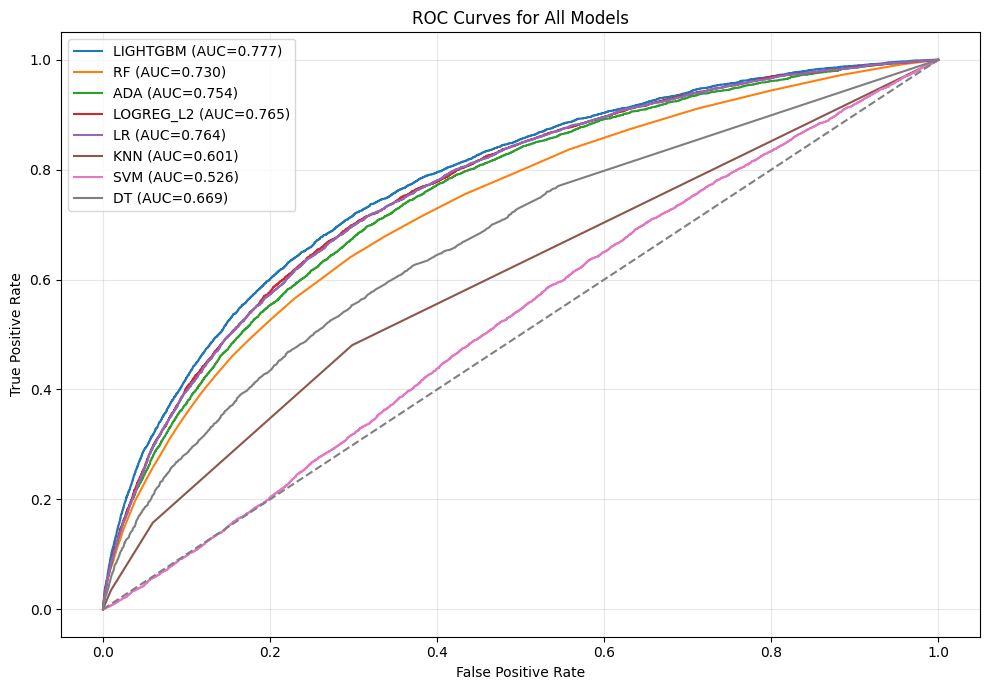

In [100]:
# ------------------- Plot ROC Curves -------------------
plt.figure(figsize=(10,7))
for model_name, (fpr, tpr, auc) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{model_name.upper()} (AUC={auc:.3f})")
plt.plot([0,1], [0,1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Hyper parameter tuning

In [101]:
# -------------------
# Define parameter grids
# -------------------
param_grids = {
    'lr': {
        'C': np.logspace(-3, 3, 7),
        'penalty': ['l2'],
        'solver': ['lbfgs'],
        'fit_intercept': [True, False]
    },
    'ridge': {
        'alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
        'fit_intercept': [True, False],
        'solver': ['auto', 'sag', 'lbfgs']
    },
    'sgd': {
        'loss': ['hinge', 'log_loss'],
        'penalty': ['l2', 'l1', 'elasticnet'],
        'alpha': [1e-4, 1e-3, 1e-2],
        'max_iter': [1000, 2000],
        'learning_rate': ['optimal', 'adaptive'],
        'eta0': [0.001, 0.01]
    },
    'svm': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'class_weight': [None, 'balanced'],
        'probability': [True]
    },
    'knn': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    },
    'dt': {
        'criterion': ['gini', 'entropy'],
        'max_depth': [4, 6, 8, None],
        'min_samples_split': [2, 10, 20],
        'min_samples_leaf': [1, 5, 10]
    },
    'rf': {
        'n_estimators': [100, 300, 500],
        'max_depth': [6, 10, None],
        'min_samples_split': [2, 10, 20],
        'min_samples_leaf': [1, 5, 10],
        'max_features': ['sqrt', 'log2']
    },
    'ada': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1.0],
        'algorithm': ['SAMME', 'SAMME.R']
    },
    'lightgbm': {
        'num_leaves': [15, 31, 63],
        'max_depth': [-1, 6, 10],
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [100, 300, 500],
        'subsample': [0.7, 0.9, 1.0],
        'colsample_bytree': [0.7, 0.9, 1.0]
    },
    'logreg_l2': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strengths (inverse)
        'tol': [1e-4, 1e-3, 1e-2],            # Tolerance for stopping criteria
        'fit_intercept': [True, False]        # Whether to fit the intercept
    }
}



 -------------------
 Define base models
 -------------------
base_models = {
    'lr': LogisticRegression(random_state=123, max_iter=1000),
    'ridge': RidgeClassifier(random_state=123),
    'sgd': SGDClassifier(random_state=123),
    'svm': SVC(random_state=123),
    'knn': KNeighborsClassifier(),
    'dt': DecisionTreeClassifier(random_state=123),
    'rf': RandomForestClassifier(random_state=123),
    'ada': AdaBoostClassifier(random_state=123),
    'lightgbm': LGBMClassifier(random_state=123)
}

In [102]:
# -------------------
# Define base models
# -------------------
base_models = {
    'lightgbm': LGBMClassifier(random_state=42, n_jobs=-1),
    'rf': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'ada': AdaBoostClassifier(random_state=42),
    'logreg_l2': LogisticRegression(penalty='l2', random_state=42, max_iter=500, n_jobs=-1),
    'lr': LogisticRegression(max_iter=500, random_state=42, n_jobs=-1, solver='saga'),
    'knn': KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, n_jobs=-1),
    'svm': SVC(kernel='linear', probability=True, random_state=42, C=1.0, max_iter=500, class_weight='balanced'),
    'dt': DecisionTreeClassifier(random_state=42, criterion='gini', max_depth=500, min_samples_split=50, min_samples_leaf=50),
}

In [103]:
# -------------------
# Run tuning
# -------------------
best_params_dict = {}
auc_scores = {}

for name, model in base_models.items():
    print(f"🔍 Tuning {name}...")
    
    # Use smaller search for heavy models
    if name in ['rf', 'lightgbm']:
        search = RandomizedSearchCV(
            model, param_distributions=param_grids[name], 
            n_iter=20, scoring='roc_auc', cv=3, n_jobs=-1, verbose=0,
            random_state=123
        )
    else:
        search = GridSearchCV(
            model, param_grid=param_grids[name], 
            scoring='roc_auc', cv=3, n_jobs=-1, verbose=0
        )
    
    search.fit(X_train, y_train)
    best_params_dict[name] = search.best_params_
    
    # Evaluate on validation
    if hasattr(search.best_estimator_, "predict_proba"):
        y_pred = search.best_estimator_.predict_proba(X_valid)[:, 1]
    else:
        y_pred = search.best_estimator_.decision_function(X_valid)
        # Scale to 0-1
        y_pred = (y_pred - y_pred.min()) / (y_pred.max() - y_pred.min())
    
    auc = roc_auc_score(y_valid, y_pred)
    auc_scores[name] = auc
    print(f"Best params for {name}: {search.best_params_}")
    print(f"Validation AUC for {name}: {auc:.4f}\n")


🔍 Tuning lightgbm...
[LightGBM] [Info] Number of positive: 13240, number of negative: 150765
[LightGBM] [Info] Number of positive: 13240, number of negative: 150765
[LightGBM] [Info] Number of positive: 13240, number of negative: 150766
[LightGBM] [Info] Number of positive: 13240, number of negative: 150765
[LightGBM] [Info] Number of positive: 13240, number of negative: 150765
[LightGBM] [Info] Number of positive: 13240, number of negative: 150766
[LightGBM] [Info] Number of positive: 13240, number of negative: 150765
[LightGBM] [Info] Number of positive: 13240, number of negative: 150766
[LightGBM] [Info] Number of positive: 13240, number of negative: 150766
[LightGBM] [Info] Number of positive: 13240, number of negative: 150765
[LightGBM] [Info] Number of positive: 13240, number of negative: 150765
[LightGBM] [Info] Number of positive: 13240, number of negative: 150765
[LightGBM] [Info] Number of positive: 13240, number of negative: 150765
[LightGBM] [Info] Number of positive: 13240

In [104]:
# -------------------
# Store results
# -------------------
results_df = pd.DataFrame({
    'Model': list(auc_scores.keys()),
    'Best_Params': [best_params_dict[m] for m in auc_scores.keys()],
    'Val_ROC_AUC': list(auc_scores.values())
}).sort_values('Val_ROC_AUC', ascending=False)
results_df

,Model,Best_Params,Val_ROC_AUC
0,lightgbm,"{'subsample': 0.9, 'num_leaves': 15, 'n_estima...",0.779923
2,ada,"{'algorithm': 'SAMME', 'learning_rate': 1.0, '...",0.762398
1,rf,"{'n_estimators': 300, 'min_samples_split': 2, ...",0.755809
7,dt,"{'criterion': 'gini', 'max_depth': 6, 'min_sam...",0.727413
3,logreg_l2,"{'C': 0.1, 'fit_intercept': False, 'tol': 0.0001}",0.608304
4,lr,"{'C': 0.1, 'fit_intercept': False, 'penalty': ...",0.608304
5,knn,"{'n_neighbors': 9, 'p': 1, 'weights': 'distance'}",0.560623
6,svm,"{'C': 0.1, 'class_weight': 'balanced', 'kernel...",0.474566


In [105]:
import pandas as pd
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [106]:
# ---- Model name to class mapping ----
model_base = {
    'lr': LogisticRegression,
    'ridge': RidgeClassifier,
    'sgd': SGDClassifier,
    'knn': KNeighborsClassifier,
    'dt': DecisionTreeClassifier,
    'rf': RandomForestClassifier,
    'logreg_l2': LogisticRegression,
    'ada': AdaBoostClassifier,
    'lightgbm': LGBMClassifier 
}

In [107]:
# Define a model factory to create model instances by name with best parameters
def create_model_instance(name, params):
    # Remove random_state from params if present to avoid duplicates
    params = params.copy()  # avoid mutating original dict
    params.pop('random_state', None)
    
    if name in ['lr', 'logreg_l2']:
        return LogisticRegression(random_state=123, max_iter=1000, n_jobs=-1, **params)
    elif name == 'lightgbm':
        return LGBMClassifier(random_state=123, n_jobs=-1, **params)
    elif name == 'ada':
        # Pass explicit random_state, exclude from params
        return AdaBoostClassifier(random_state=123, **params)
    elif name == 'rf':
        return RandomForestClassifier(random_state=123, n_jobs=-1, **params)
    elif name == 'dt':
        return DecisionTreeClassifier(random_state=123, **params)
    elif name == 'knn':
        return KNeighborsClassifier(**params)
    else:
        raise ValueError(f"Model name {name} not recognized or supported.")

In [108]:
from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score, roc_auc_score,
    roc_curve, confusion_matrix
)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Import classifiers
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [109]:
# Models that require scaling (linear models, distance-based)
models_need_scaling = ['lr', 'logreg_l2', 'knn']


Building model: lightgbm with best params: {'subsample': 0.9, 'num_leaves': 15, 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35886
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 240
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482


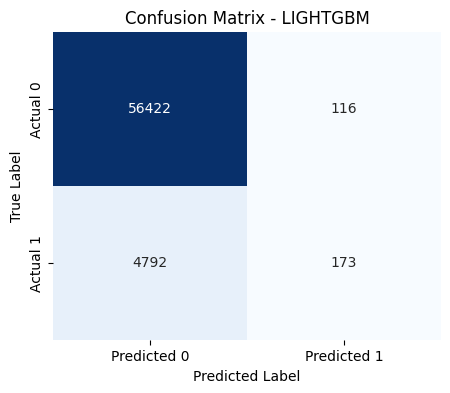


Building model: ada with best params: {'algorithm': 'SAMME', 'learning_rate': 1.0, 'n_estimators': 200}


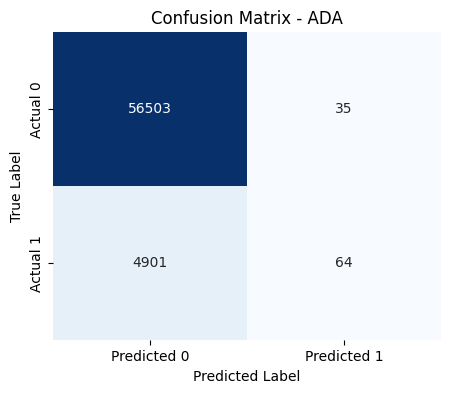


Building model: rf with best params: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'max_depth': None}


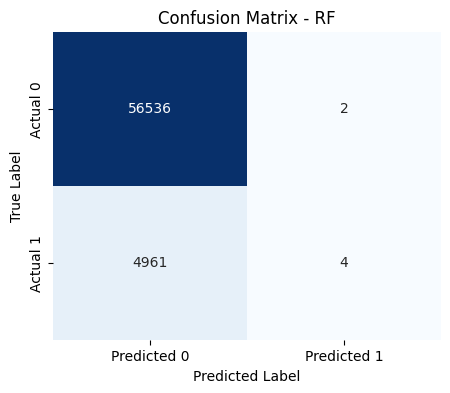


Building model: dt with best params: {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 10, 'min_samples_split': 2}


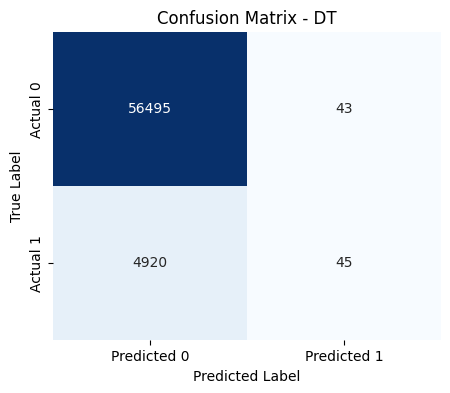


Building model: logreg_l2 with best params: {'C': 0.1, 'fit_intercept': False, 'tol': 0.0001}


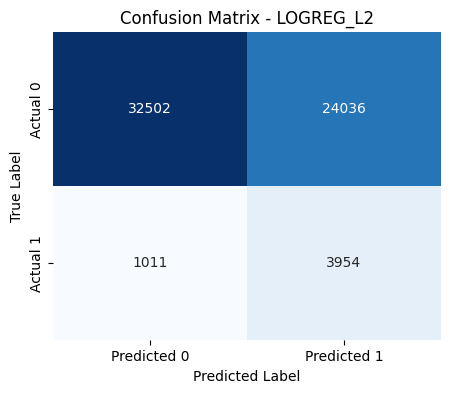


Building model: lr with best params: {'C': np.float64(0.1), 'fit_intercept': False, 'penalty': 'l2', 'solver': 'lbfgs'}


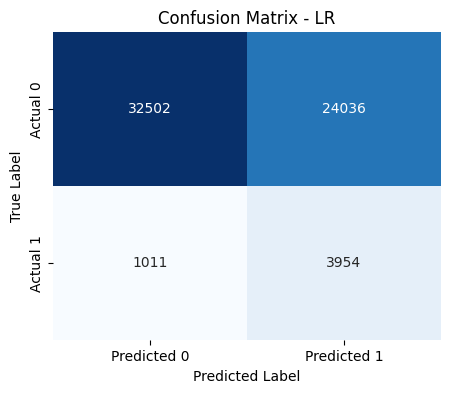


Building model: knn with best params: {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}


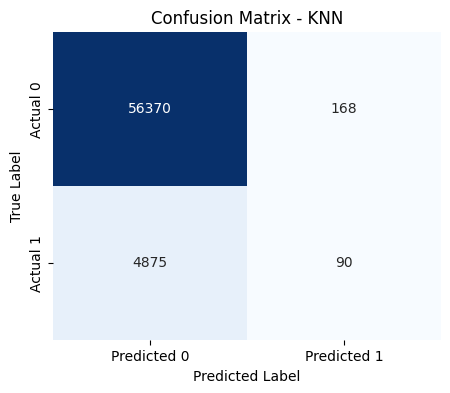

Model svm not recognized, skipping...


In [110]:
# Prepare metric storage and ROC data
metrics_list = []
roc_curves = {}

# Define imputers and scalers
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

for idx, row in results_df.iterrows():
    model_name = row['Model']
    best_params = row['Best_Params']
    if model_name not in model_base:
        print(f"Model {model_name} not recognized, skipping...")
        continue
    print(f"\nBuilding model: {model_name} with best params: {best_params}")
    
    model = create_model_instance(model_name, best_params)
    
    # Preprocess data according to model requirement
    if model_name in models_need_scaling:
        X_train_pp = imputer.fit_transform(X_train)
        X_train_pp = scaler.fit_transform(X_train_pp)
        X_valid_pp = imputer.transform(X_valid)
        X_valid_pp = scaler.transform(X_valid_pp)
    else:
        X_train_pp = imputer.fit_transform(X_train)
        X_valid_pp = imputer.transform(X_valid)
    
    # Fit model
    model.fit(X_train_pp, y_train)
    
    # Predict probabilities or decision function, ensuring probabilities for auc
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_valid_pp)[:, 1]
    else:
        y_pred_proba = model.decision_function(X_valid_pp)
        # Scale to [0,1]
        y_pred_proba = (y_pred_proba - np.min(y_pred_proba)) / (np.max(y_pred_proba) - np.min(y_pred_proba))
    
    # Predict class labels using 0.5 threshold
    y_pred = (y_pred_proba >= 0.5).astype(int)
    
    # Calculate metrics
    precision = precision_score(y_valid, y_pred, zero_division=0)
    recall = recall_score(y_valid, y_pred, zero_division=0)
    f1 = f1_score(y_valid, y_pred, zero_division=0)
    accuracy = accuracy_score(y_valid, y_pred)
    auc = roc_auc_score(y_valid, y_pred_proba)
    
    metrics_list.append({
        'Model': model_name,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1,
        'Accuracy': accuracy,
        'ROC_AUC': auc
    })
    
    fpr, tpr, _ = roc_curve(y_valid, y_pred_proba)
    roc_curves[model_name] = (fpr, tpr, auc)
    
    # Plot confusion matrix as heatmap
    cm = confusion_matrix(y_valid, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'Confusion Matrix - {model_name.upper()}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


In [111]:
metrics_df = pd.DataFrame(metrics_list).sort_values('ROC_AUC', ascending=False).reset_index(drop=True)
print("\nModel comparison on validation ")
metrics_df


Model comparison on validation 


,Model,Precision,Recall,F1_Score,Accuracy,ROC_AUC
0,lightgbm,0.598616,0.034844,0.065855,0.920199,0.780257
1,logreg_l2,0.141265,0.796375,0.239964,0.592752,0.762506
2,lr,0.141265,0.796375,0.239964,0.592752,0.762506
3,ada,0.646465,0.012890,0.025276,0.919744,0.762398
4,rf,0.666667,0.000806,0.001609,0.919305,0.756180
5,dt,0.511364,0.009063,0.017811,0.919305,0.727413
6,knn,0.348837,0.018127,0.034463,0.918004,0.636189


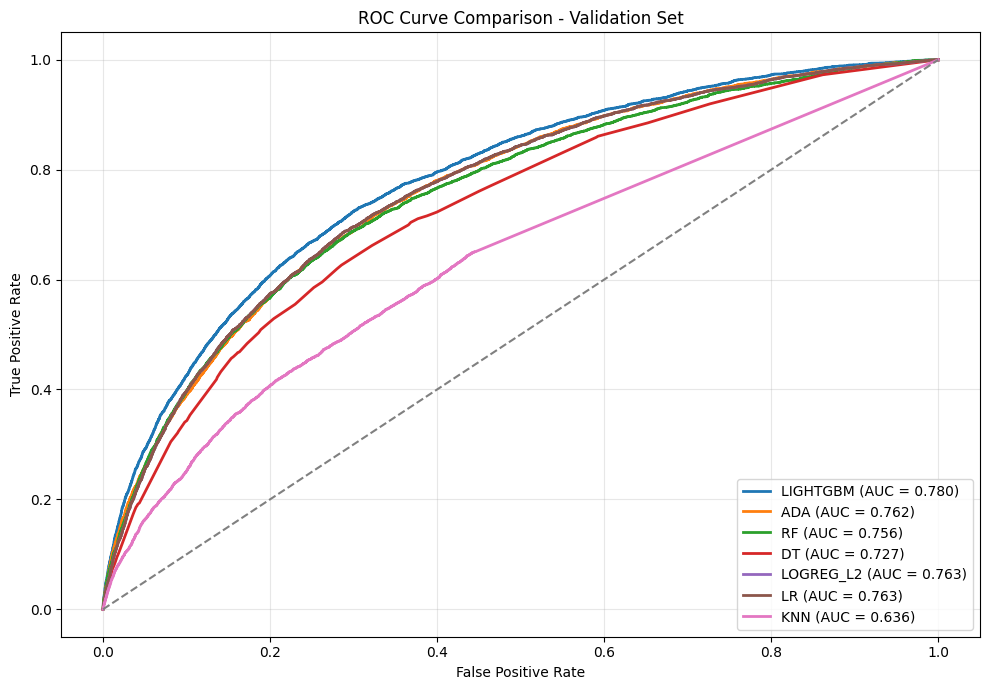

In [112]:
# Plot ROC curves for all models together
plt.figure(figsize=(10, 7))
for model_name, (fpr, tpr, auc) in roc_curves.items():
    plt.plot(fpr, tpr, lw=2, label=f"{model_name.upper()} (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison - Validation Set')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [113]:
# -------------------
# Define base models
# -------------------
base_models = {
    'lightgbm': LGBMClassifier(random_state=42, n_jobs=-1),
    'rf': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'ada': AdaBoostClassifier(random_state=42),
    'logreg_l2': LogisticRegression(penalty='l2', random_state=42, max_iter=500, n_jobs=-1),
    'lr': LogisticRegression(max_iter=500, random_state=42, n_jobs=-1, solver='saga'),
    'knn': KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, n_jobs=-1),
    'svm': SVC(kernel='linear', probability=True, random_state=42, C=1.0, max_iter=500, class_weight='balanced'),
    'dt': DecisionTreeClassifier(random_state=42, criterion='gini', max_depth=500, min_samples_split=50, min_samples_leaf=50),
}

In [ ]:
# -------------------
# Run tuning
# -------------------
best_params_dict = {}
auc_scores = {}

for name, model in base_models.items():
    print(f"Tuning {name}...")
    
    # Use smaller search for heavy models
    if name in ['rf', 'lightgbm']:
        search = RandomizedSearchCV(
            model, param_distributions=param_grids[name], 
            n_iter=20, scoring='accuracy', cv=3, n_jobs=-1, verbose=0,
            random_state=123
        )
    else:
        search = GridSearchCV(
            model, param_grid=param_grids[name], 
            scoring='accuracy', cv=3, n_jobs=-1, verbose=0
        )
    
    search.fit(X_train, y_train)
    best_params_dict[name] = search.best_params_
    
    # Evaluate on validation
    if hasattr(search.best_estimator_, "predict_proba"):
        y_pred = search.best_estimator_.predict_proba(X_valid)[:, 1]
    else:
        y_pred = search.best_estimator_.decision_function(X_valid)
        # Scale to 0-1
        y_pred = (y_pred - y_pred.min()) / (y_pred.max() - y_pred.min())
    
    auc = roc_auc_score(y_valid, y_pred)
    auc_scores[name] = auc
    print(f"Best params for {name}: {search.best_params_}")
    print(f"Validation AUC for {name}: {auc:.4f}\n")


🔍 Tuning lightgbm...
[LightGBM] [Info] Number of positive: 13240, number of negative: 150766
[LightGBM] [Info] Number of positive: 13240, number of negative: 150765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.167197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35854
[LightGBM] [Info] Number of data points in the train set: 164006, number of used features: 239
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35726
[LightGBM] [Info] Number of data points in the train set: 164005, number of used features: 239
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432480
[LightGBM] [Info] Start training from

In [115]:
# -------------------
# Store results
# -------------------
results_acc_df = pd.DataFrame({
    'Model': list(auc_scores.keys()),
    'Best_Params': [best_params_dict[m] for m in auc_scores.keys()],
    'Val_ROC_AUC': list(auc_scores.values())
}).sort_values('Val_ROC_AUC', ascending=False)
results_acc_df

,Model,Best_Params,Val_ROC_AUC
0,lightgbm,"{'subsample': 0.9, 'num_leaves': 15, 'n_estima...",0.779923
2,ada,"{'algorithm': 'SAMME', 'learning_rate': 1.0, '...",0.762398
1,rf,"{'n_estimators': 100, 'min_samples_split': 2, ...",0.745030
7,dt,"{'criterion': 'gini', 'max_depth': 4, 'min_sam...",0.720336
3,logreg_l2,"{'C': 10, 'fit_intercept': False, 'tol': 0.0001}",0.606588
4,lr,"{'C': 10.0, 'fit_intercept': False, 'penalty':...",0.606588
5,knn,"{'n_neighbors': 9, 'p': 2, 'weights': 'uniform'}",0.552842
6,svm,"{'C': 0.1, 'class_weight': None, 'kernel': 'li...",0.467383


In [116]:
# ---- Model name to class mapping ----
model_base = {
    'lr': LogisticRegression,
    'ridge': RidgeClassifier,
    'sgd': SGDClassifier,
    'knn': KNeighborsClassifier,
    'dt': DecisionTreeClassifier,
    'rf': RandomForestClassifier,
    'logreg_l2': LogisticRegression,
    'ada': AdaBoostClassifier,
    'lightgbm': LGBMClassifier 
}


Building model: lightgbm with best params: {'subsample': 0.9, 'num_leaves': 15, 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35886
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 240
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482


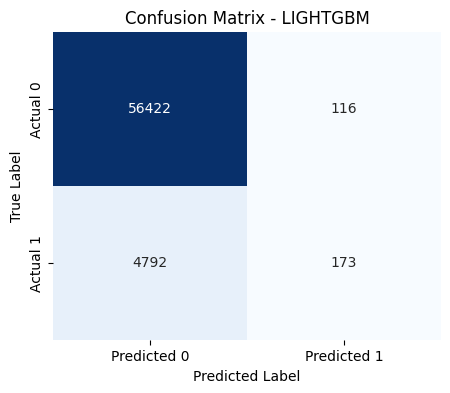


Building model: ada with best params: {'algorithm': 'SAMME', 'learning_rate': 1.0, 'n_estimators': 200}


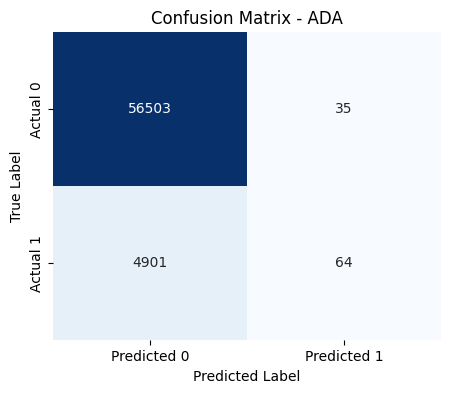


Building model: rf with best params: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': None}


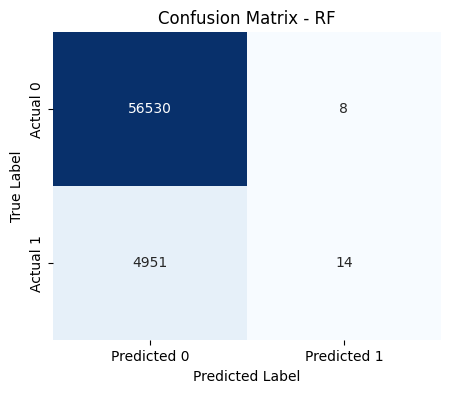


Building model: dt with best params: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}


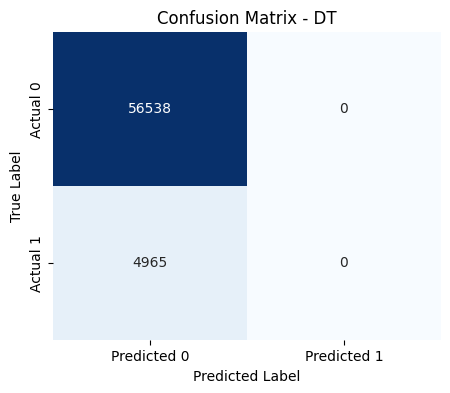


Building model: logreg_l2 with best params: {'C': 10, 'fit_intercept': False, 'tol': 0.0001}


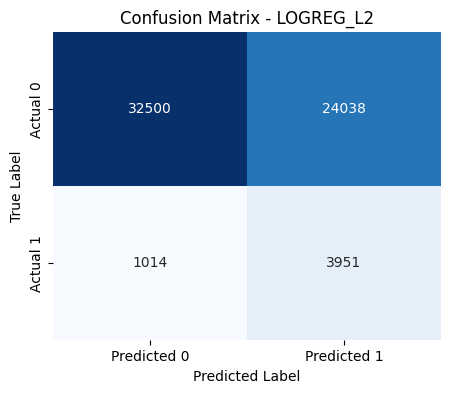


Building model: lr with best params: {'C': np.float64(10.0), 'fit_intercept': False, 'penalty': 'l2', 'solver': 'lbfgs'}


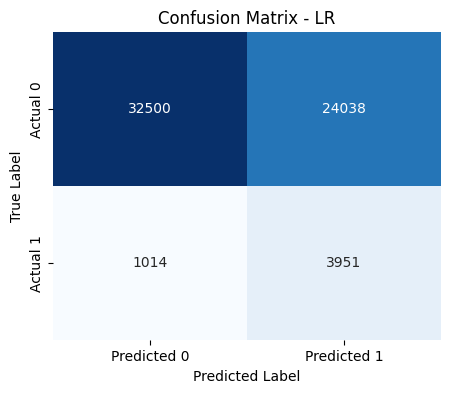


Building model: knn with best params: {'n_neighbors': 9, 'p': 2, 'weights': 'uniform'}


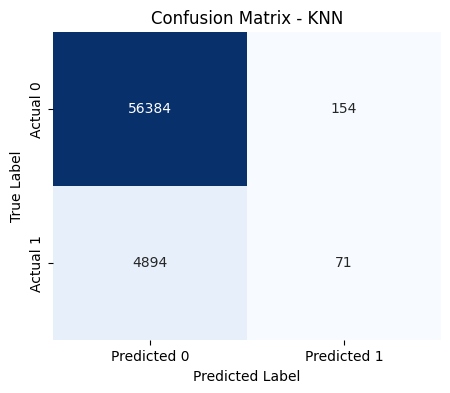

Model svm not recognized, skipping...


In [117]:
# Prepare metric storage and ROC data
metrics_list = []
roc_curves = {}

# Define imputers and scalers
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

for idx, row in results_acc_df.iterrows():
    model_name = row['Model']
    best_params = row['Best_Params']
    if model_name not in model_base:
        print(f"Model {model_name} not recognized, skipping...")
        continue
    print(f"\nBuilding model: {model_name} with best params: {best_params}")
    
    model = create_model_instance(model_name, best_params)
    
    # Preprocess data according to model requirement
    if model_name in models_need_scaling:
        X_train_pp = imputer.fit_transform(X_train)
        X_train_pp = scaler.fit_transform(X_train_pp)
        X_valid_pp = imputer.transform(X_valid)
        X_valid_pp = scaler.transform(X_valid_pp)
    else:
        X_train_pp = imputer.fit_transform(X_train)
        X_valid_pp = imputer.transform(X_valid)
    
    # Fit model
    model.fit(X_train_pp, y_train)
    
    # Predict probabilities or decision function, ensuring probabilities for auc
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_valid_pp)[:, 1]
    else:
        y_pred_proba = model.decision_function(X_valid_pp)
        # Scale to [0,1]
        y_pred_proba = (y_pred_proba - np.min(y_pred_proba)) / (np.max(y_pred_proba) - np.min(y_pred_proba))
    
    # Predict class labels using 0.5 threshold
    y_pred = (y_pred_proba >= 0.5).astype(int)
    
    # Calculate metrics
    precision = precision_score(y_valid, y_pred, zero_division=0)
    recall = recall_score(y_valid, y_pred, zero_division=0)
    f1 = f1_score(y_valid, y_pred, zero_division=0)
    accuracy = accuracy_score(y_valid, y_pred)
    auc = roc_auc_score(y_valid, y_pred_proba)
    
    metrics_list.append({
        'Model': model_name,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1,
        'Accuracy': accuracy,
        'ROC_AUC': auc
    })
    
    fpr, tpr, _ = roc_curve(y_valid, y_pred_proba)
    roc_curves[model_name] = (fpr, tpr, auc)
    
    # Plot confusion matrix as heatmap
    cm = confusion_matrix(y_valid, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'Confusion Matrix - {model_name.upper()}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


In [118]:
metrics_df = pd.DataFrame(metrics_list).sort_values('ROC_AUC', ascending=False).reset_index(drop=True)
print("\nModel comparison on validation ")
metrics_df


Model comparison on validation 


,Model,Precision,Recall,F1_Score,Accuracy,ROC_AUC
0,lightgbm,0.598616,0.034844,0.065855,0.920199,0.780257
1,logreg_l2,0.141163,0.795770,0.239789,0.592670,0.762450
2,lr,0.141163,0.795770,0.239789,0.592670,0.762450
3,ada,0.646465,0.012890,0.025276,0.919744,0.762398
4,rf,0.636364,0.002820,0.005615,0.919370,0.745411
5,dt,0.000000,0.000000,0.000000,0.919272,0.720336
6,knn,0.315556,0.014300,0.027360,0.917923,0.631703


### Introducing synthetic data using SMOTE as we have imbalance data

In [119]:
# 1. Preparing data Copying it to a new DataFrame
df = application_train.copy()
X = df.drop(columns=['SK_ID_CURR', 'TARGET'])
y = df['TARGET']

In [120]:
# 2. Split into train and validation set BEFORE applying SMOTE!
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.3,  # 30% for validation
    random_state=42,
    stratify=y
)

In [121]:
from imblearn.over_sampling import SMOTE

In [122]:
# 4. Apply SMOTE only on the training data
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [123]:
application_train.TARGET.value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

<Axes: title={'center': 'Top 30 Feature Importances'}>

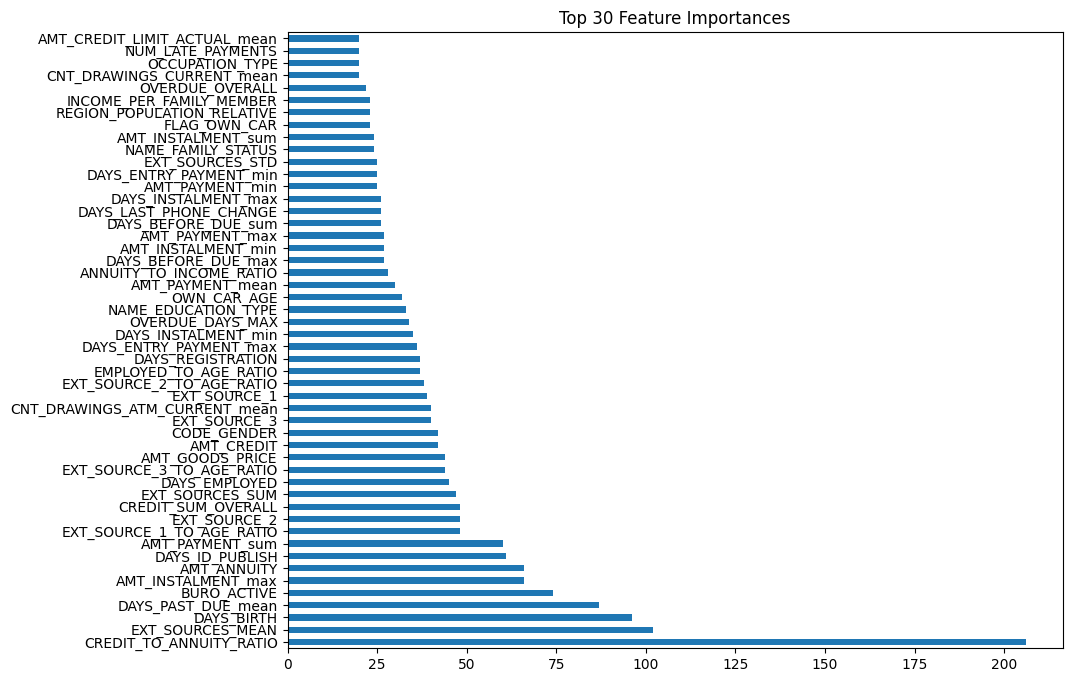

In [130]:
feat_imp.head(50).plot(kind='barh', figsize=(10, 8), title='Top 30 Feature Importances')

In [131]:
feat_imp.head(50).index.tolist()

['CREDIT_TO_ANNUITY_RATIO',
 'EXT_SOURCES_MEAN',
 'DAYS_BIRTH',
 'DAYS_PAST_DUE_mean',
 'BURO_ACTIVE',
 'AMT_INSTALMENT_max',
 'AMT_ANNUITY',
 'DAYS_ID_PUBLISH',
 'AMT_PAYMENT_sum',
 'EXT_SOURCE_1_TO_AGE_RATIO',
 'EXT_SOURCE_2',
 'CREDIT_SUM_OVERALL',
 'EXT_SOURCES_SUM',
 'DAYS_EMPLOYED',
 'EXT_SOURCE_3_TO_AGE_RATIO',
 'AMT_GOODS_PRICE',
 'AMT_CREDIT',
 'CODE_GENDER',
 'EXT_SOURCE_3',
 'CNT_DRAWINGS_ATM_CURRENT_mean',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2_TO_AGE_RATIO',
 'EMPLOYED_TO_AGE_RATIO',
 'DAYS_REGISTRATION',
 'DAYS_ENTRY_PAYMENT_max',
 'DAYS_INSTALMENT_min',
 'OVERDUE_DAYS_MAX',
 'NAME_EDUCATION_TYPE',
 'OWN_CAR_AGE',
 'AMT_PAYMENT_mean',
 'ANNUITY_TO_INCOME_RATIO',
 'DAYS_BEFORE_DUE_max',
 'AMT_INSTALMENT_min',
 'AMT_PAYMENT_max',
 'DAYS_BEFORE_DUE_sum',
 'DAYS_LAST_PHONE_CHANGE',
 'DAYS_INSTALMENT_max',
 'AMT_PAYMENT_min',
 'DAYS_ENTRY_PAYMENT_min',
 'EXT_SOURCES_STD',
 'NAME_FAMILY_STATUS',
 'AMT_INSTALMENT_sum',
 'FLAG_OWN_CAR',
 'REGION_POPULATION_RELATIVE',
 'INCOME_PER_FAMILY